In [1]:
import pandas as pd

df = pd.read_csv('C:/Users/Debrachoubey/PycharmProjects/pythonProject/first_100k_records_europe.csv')
# Step 1: Drop unnecessary columns
columns_to_drop = ['transaction_id', 'customer_id', 'card_number', 'device_fingerprint', 'ip_address', 'currency' , 'city' , 'city_size' ,'high_risk_merchant' , 'timestamp']
df_cleaned = df.drop(columns=columns_to_drop)
#Step 2: Convert timestamp to datetime
#df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

# Extract new features from timestamp
#df_cleaned['transaction_hour'] = df_cleaned['timestamp'].dt.hour
#df_cleaned['transaction_day'] = df_cleaned['timestamp'].dt.day
#df_cleaned['transaction_weekday'] = df_cleaned['timestamp'].dt.weekday  # Monday=0, Sunday=6
#df_cleaned['transaction_weekend'] = df_cleaned['transaction_weekday'] >= 5  # True if Saturday or Sunday
# Extract time of day (Morning, Afternoon, Evening, Night)
def time_of_day(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"

df_cleaned['time_of_day'] = df_cleaned['transaction_hour'].apply(time_of_day)
#df_cleaned.to_csv('output.csv', index=False)  # Set index=False to avoid saving the index column

#print("CSV file saved successfully!")
# Step 3: Extract velocity_last_hour details (JSON-like data)
import ast

def extract_velocity_features(value):
    if isinstance(value, str):  # If the column contains dictionary-like strings
        try:
            value = ast.literal_eval(value)  # Convert string to dictionary
            return pd.Series([value.get('num_transactions', 0), value.get('total_amount', 0.0)])
        except:
            return pd.Series([0, 0.0])  # Handle errors gracefully
    else:
        return pd.Series([0, 0.0])

df_cleaned[['num_transactions_last_hour', 'total_amount_last_hour']] = df_cleaned['velocity_last_hour'].apply(extract_velocity_features)
df_cleaned.drop(columns=['velocity_last_hour'], inplace=True)  # Remove original JSON-like column
print(df_cleaned.dtypes)  # Identify boolean columns

# Step 4: Encode categorical variables (One-Hot Encoding for nominal, Label Encoding for ordinal if needed)
categorical_columns = ['merchant_category', 'merchant_type', 'country','card_type', 'device', 'channel' , 'time_of_day']
df_encoded = pd.get_dummies(df_cleaned,columns=categorical_columns, drop_first=True)
# Step 5: Check for correlations among numerical features
#correlation_matrix = df_encoded.corr()

merchant_category              object
merchant_type                  object
merchant                       object
amount                        float64
country                        object
card_type                      object
card_present                     bool
device                         object
channel                        object
distance_from_home              int64
transaction_hour                int64
weekend_transaction              bool
is_fraud                         bool
time_of_day                    object
num_transactions_last_hour    float64
total_amount_last_hour        float64
dtype: object


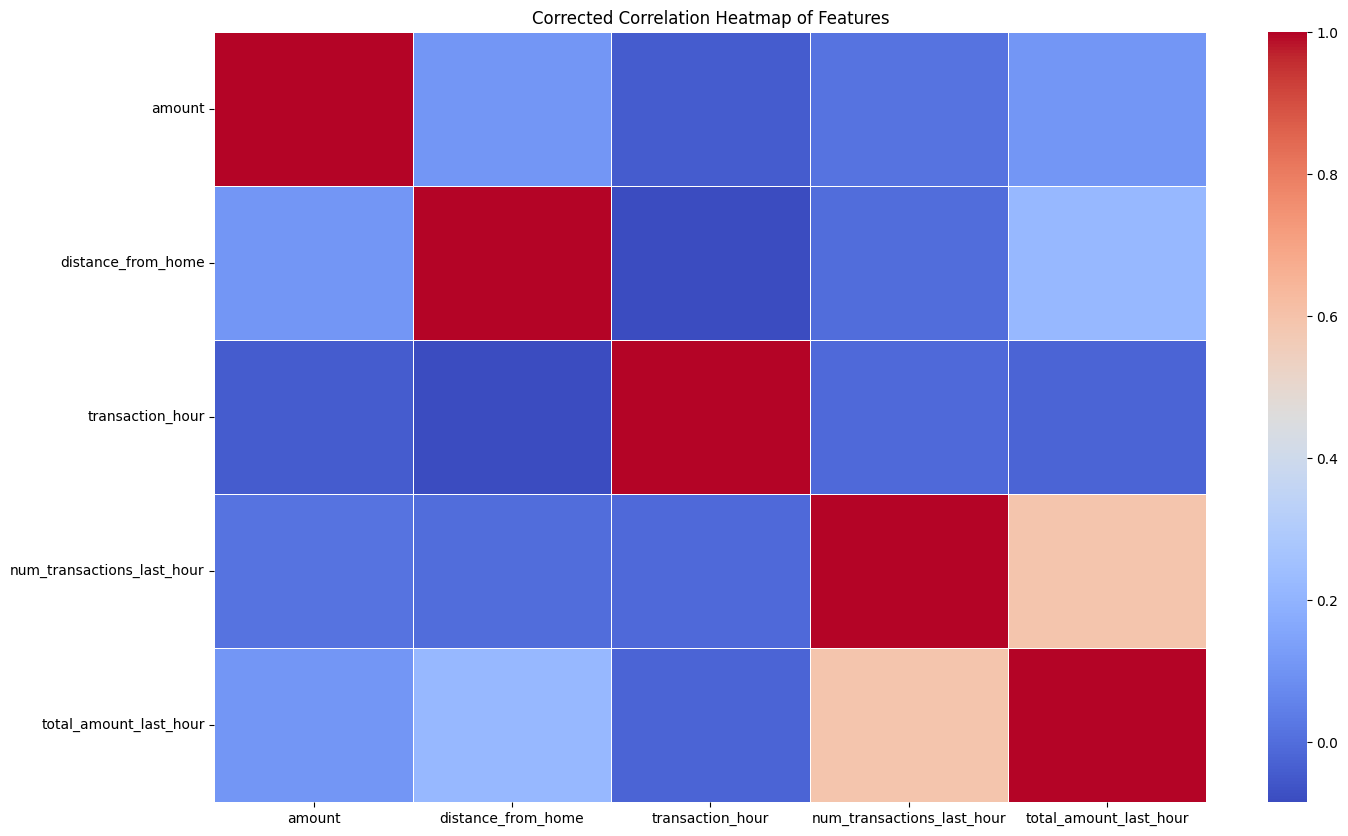

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Select Only Numerical Columns
numerical_columns = df_encoded.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df_encoded[numerical_columns].corr()

# Step 2: Plot Heatmap
plt.figure(figsize=(16, 10))  # Increase figure size
sns.heatmap(
    correlation_matrix,
    annot=False,  # Set to True if you want to see correlation values
    cmap='coolwarm',
    linewidths=0.5
)
plt.title("Corrected Correlation Heatmap of Features")
plt.show()

                            amount  distance_from_home  transaction_hour  \
amount                         1.0                 NaN               NaN   
distance_from_home             NaN                 1.0               NaN   
transaction_hour               NaN                 NaN               1.0   
num_transactions_last_hour     NaN                 NaN               NaN   
total_amount_last_hour         NaN                 NaN               NaN   

                            num_transactions_last_hour  total_amount_last_hour  
amount                                             NaN                     NaN  
distance_from_home                                 NaN                     NaN  
transaction_hour                                   NaN                     NaN  
num_transactions_last_hour                    1.000000                0.591622  
total_amount_last_hour                        0.591622                1.000000  


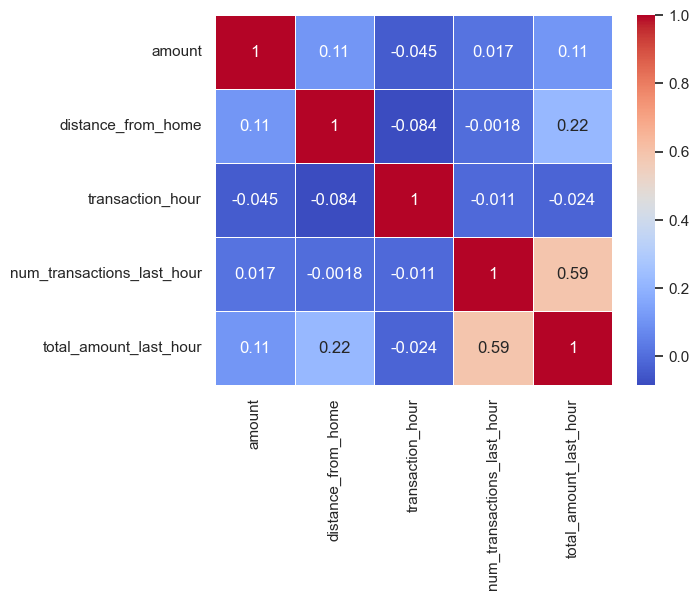

In [88]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
strong_corr = correlation_matrix[abs(correlation_matrix) > 0.5]
print(strong_corr)

<Axes: xlabel='num_transactions_last_hour', ylabel='total_amount_last_hour'>

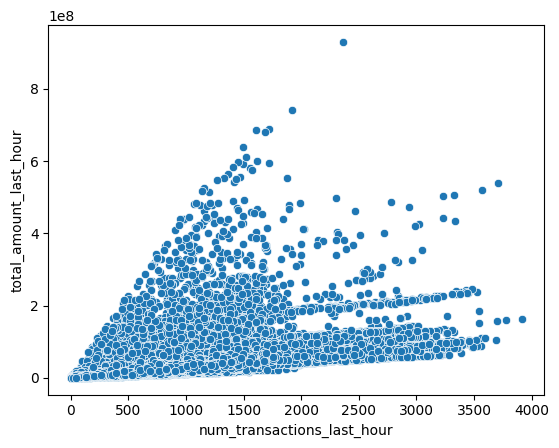

In [3]:
import seaborn as sns
sns.scatterplot(x=df_encoded['num_transactions_last_hour'], y=df_encoded['total_amount_last_hour'])

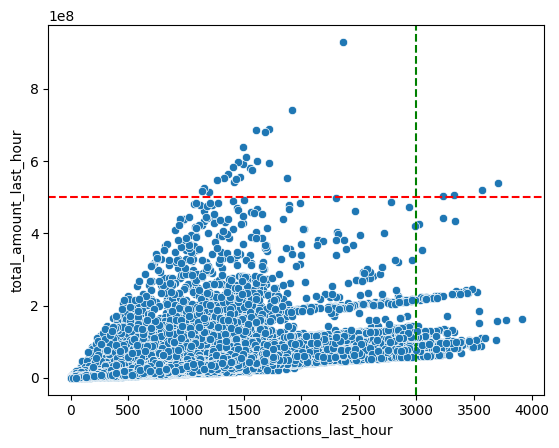

In [4]:
sns.scatterplot(x=df_encoded['num_transactions_last_hour'], y=df_encoded['total_amount_last_hour'])
plt.axhline(y=5e8, color='r', linestyle='--')  # Marking a threshold
plt.axvline(x=3000, color='g', linestyle='--')  # Marking a threshold
plt.show()

In [5]:
df_encoded[['num_transactions_last_hour', 'total_amount_last_hour']].corr()

,num_transactions_last_hour,total_amount_last_hour
num_transactions_last_hour,1.000000,0.591622
total_amount_last_hour,0.591622,1.000000


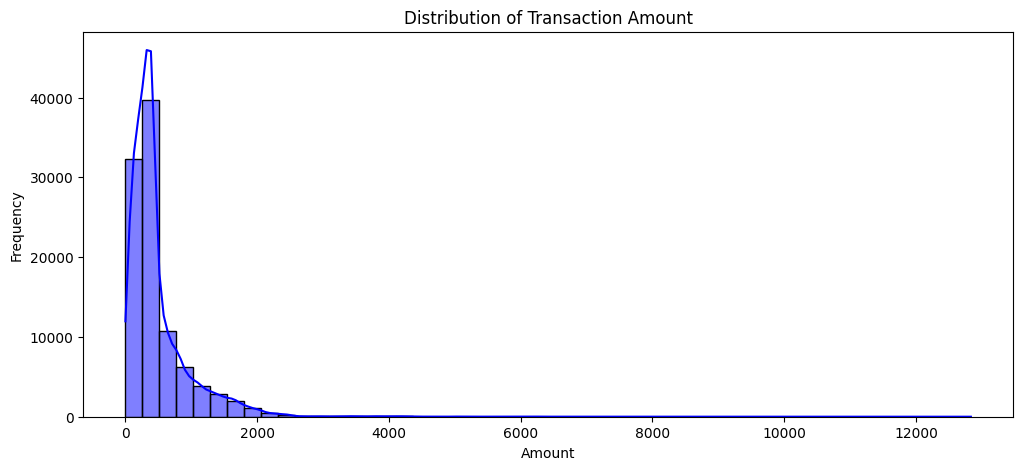

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of 'amount'
plt.figure(figsize=(12, 5))
sns.histplot(df_cleaned['amount'], bins=50, kde=True, color='blue')
plt.title("Distribution of Transaction Amount")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

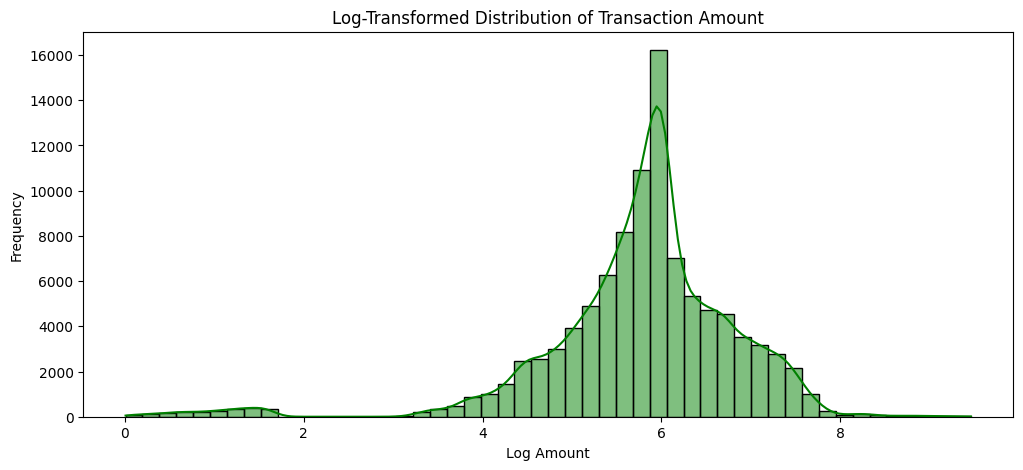

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply log transformation
df_cleaned['log_amount'] = np.log1p(df_encoded['amount'])  # log(1 + amount) to avoid log(0) errors

# Plot the transformed distribution
plt.figure(figsize=(12, 5))
sns.histplot(df_cleaned['log_amount'], bins=50, kde=True, color='green')
plt.title("Log-Transformed Distribution of Transaction Amount")
plt.xlabel("Log Amount")
plt.ylabel("Frequency")
plt.show()

In [10]:
import numpy as np
#from category_encoders import TargetEncoder
#from sklearn.preprocessing import OneHotEncoder

# Step 1: Drop Weakly Correlated Features
df_selected = df_cleaned.drop(columns=['transaction_hour','amount'], errors='ignore')

# Step 2: Define Thresholds for Anomalous Transactions
high_transactions_threshold = df_selected['num_transactions_last_hour'].quantile(0.95)  # Top 5%
high_amount_threshold = df_selected['total_amount_last_hour'].quantile(0.95)  # Top 5%
long_distance_threshold = df_selected['distance_from_home'].quantile(0.95)  # Top 5%

# Step 3: Create Fraud Indicators

# High Transaction Flag: User made an unusually high number of transactions in the last hour
df_selected['high_transaction_flag'] = (
    df_selected['num_transactions_last_hour'] > high_transactions_threshold
).astype(int)

# High Spending Flag: User spent an unusually high amount in the last hour
df_selected['high_spending_flag'] = (
    df_selected['total_amount_last_hour'] > high_amount_threshold
).astype(int)

# Long Distance Spending Flag: Large amount spent far from home
df_selected['long_distance_spender'] = (
    (df_selected['distance_from_home'] > long_distance_threshold) & 
    (df_selected['log_amount'] > high_amount_threshold)
).astype(int)

# Velocity-Based Risk Score: Combine transactions & amount in one feature
df_selected['velocity_risk_score'] = (
    df_selected['num_transactions_last_hour'] * 0.5 + df_selected['total_amount_last_hour'] * 0.5
)



# Step 5: Encode Categorical Features
from sklearn.preprocessing import LabelEncoder
categorical_columns = ['merchant_category', 'merchant_type', 'merchant', 'country', 'card_type', 'card_present','device', 'channel']
for col in categorical_columns:
    if col in df_selected.columns:
        df_selected[col] = LabelEncoder().fit_transform(df_selected[col])


# Fixing the encoding process with error handling and checking for column existence

#from sklearn.preprocessing import OneHotEncoder

# Define categorical columns and encoding strategy
#target_encode_cols = ['merchant_category', 'merchant_type', 'merchant', 'card_type']  # Target Encoding
#drop_cols = ['country']  # Dropped due to minimal impact
#binary_encode_cols = ['card_present']  # Binary Encoding (0/1)
#one_hot_encode_cols = ['device', 'channel']  # Selective One-Hot Encoding

# Apply Target Encoding manually (since category_encoders is unavailable)
#for col in target_encode_cols:
    #if col in df_selected.columns:
       # fraud_rates = df_selected.groupby(col)['is_fraud'].mean()
        #df_selected[col] = df_selected[col].map(fraud_rates)

# Apply Binary Encoding (0 = No, 1 = Yes) if the column exists
#if 'card_present' in df_selected.columns:
    #df_selected['card_present'] = df_selected['card_present'].astype(int)

# Apply One-Hot Encoding (for high-risk categories only) if columns exist
#available_one_hot_encode_cols = [col for col in one_hot_encode_cols if col in df_selected.columns]

#if available_one_hot_encode_cols:
    #one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid dummy variable trap
    #one_hot_encoded = one_hot_encoder.fit_transform(df_selected[available_one_hot_encode_cols])

    # Convert One-Hot Encoded data to DataFrame
    #one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(available_one_hot_encode_cols))

    # Drop original one-hot encoded columns and concatenate new encoded features
    #df_selected = df_selected.drop(columns=available_one_hot_encode_cols)
    #df_selected = pd.concat([df_selected, one_hot_encoded_df], axis=1)

# Drop unnecessary columns if they exist
#df_selected = df_selected.drop(columns=[col for col in drop_cols if col in df_selected.columns], errors='ignore')

# Display updated dataset
#tools.display_dataframe_to_user(name="Encoded Fraud Dataset", dataframe=df_selected)


# Display the processed dataset
from IPython.display import display

# Display the cleaned DataFrame
selected_features = ['log_amount', 'num_transactions_last_hour', 'total_amount_last_hour', 'velocity_risk_score']
display(df_selected[selected_features].head())
display(df_selected.dtypes)

,log_amount,num_transactions_last_hour,total_amount_last_hour,velocity_risk_score
0,6.720618,352.0,8.690903e+06,4.345628e+06
1,6.273952,600.0,1.766378e+07,8.832190e+06
2,5.590726,181.0,1.715528e+06,8.578547e+05
3,6.493603,24.0,7.220302e+06,3.610163e+06
4,7.021120,235.0,3.605757e+06,1.802996e+06


merchant_category               int64
merchant_type                   int64
merchant                        int64
country                         int64
card_type                       int64
card_present                    int64
device                          int64
channel                         int64
distance_from_home              int64
weekend_transaction              bool
is_fraud                         bool
time_of_day                    object
num_transactions_last_hour    float64
total_amount_last_hour        float64
log_amount                    float64
high_transaction_flag           int64
high_spending_flag              int64
long_distance_spender           int64
velocity_risk_score           float64
dtype: object

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset (Ensure it has the engineered fraud indicators and is_fraud column)
#df = pd.read_csv("processed_fraud_dataset.csv")  # Replace with your dataset path

# Define fraud indicators
fraud_indicators = ['high_transaction_flag', 'high_spending_flag', 'long_distance_spender']

# Calculate fraud rate for each fraud indicator
fraud_rates = {}
for feature in fraud_indicators:
    fraud_rates[feature] = df_selected[df_selected[feature] == 1]['is_fraud'].mean() * 100  # Percentage of frauds

# Convert to DataFrame
fraud_rates_df = pd.DataFrame(list(fraud_rates.items()), columns=['Fraud Indicator', 'Fraud Percentage'])
print ('fraud_rates_df',fraud_rates_df)

fraud_rates_df          Fraud Indicator  Fraud Percentage
0  high_transaction_flag           7.80341
1     high_spending_flag          17.76000
2  long_distance_spender               NaN


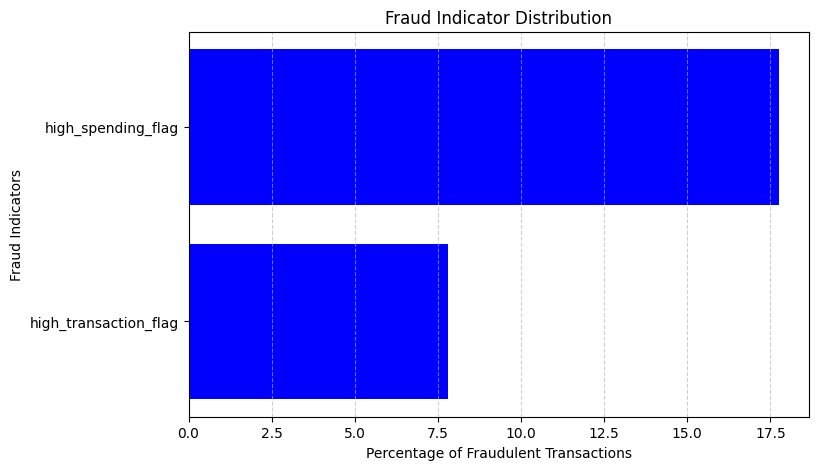

In [12]:
# Plot the fraud distribution per indicator
plt.figure(figsize=(8, 5))
plt.barh(fraud_rates_df['Fraud Indicator'], fraud_rates_df['Fraud Percentage'], color='blue')

# Formatting
plt.xlabel("Percentage of Fraudulent Transactions")
plt.ylabel("Fraud Indicators")
plt.title("Fraud Indicator Distribution")
plt.grid(axis='x', linestyle="--", alpha=0.6)

# Show the plot
plt.show()

In [13]:
selected_features = ['log_amount', 'num_transactions_last_hour', 'total_amount_last_hour', 'velocity_risk_score']
# Create a new DataFrame with only the selected columns
#df_selected = df[selected_features]
display(df_selected.head())

,merchant_category,merchant_type,merchant,country,card_type,card_present,device,channel,distance_from_home,weekend_transaction,is_fraud,time_of_day,num_transactions_last_hour,total_amount_last_hour,log_amount,high_transaction_flag,high_spending_flag,long_distance_spender,velocity_risk_score
0,7,6,100,1,3,0,3,2,0,False,False,Night,352.0,8.690903e+06,6.720618,0,0,0,4.345628e+06
1,4,11,25,0,2,0,3,2,0,False,False,Night,600.0,1.766378e+07,6.273952,0,0,0,8.832190e+06
2,5,13,65,1,0,0,0,0,0,False,False,Night,181.0,1.715528e+06,5.590726,0,0,0,8.578547e+05
3,1,3,81,1,3,0,4,2,1,False,False,Night,24.0,7.220302e+06,6.493603,0,0,0,3.610163e+06
4,7,0,7,1,4,0,7,2,0,False,False,Night,235.0,3.605757e+06,7.021120,0,0,0,1.802996e+06


In [14]:
from sklearn.preprocessing import StandardScaler
selected_features = ['log_amount', 'num_transactions_last_hour', 'total_amount_last_hour', 'velocity_risk_score']
# Create a new DataFrame with only the selected columns
#df_selected = df[selected_features]
display(df_selected.head())

# Select features that need scaling
features_to_scale = ['log_amount', 'num_transactions_last_hour', 'total_amount_last_hour', 'velocity_risk_score']

# Initialize the scaler
scaler = StandardScaler()

# Apply standard scaling
df_selected[features_to_scale] = scaler.fit_transform(df_selected[features_to_scale])

# Display the processed dataset
from IPython.display import display

# Display the cleaned DataFrame
display(df_selected[features_to_scale].head())

,merchant_category,merchant_type,merchant,country,card_type,card_present,device,channel,distance_from_home,weekend_transaction,is_fraud,time_of_day,num_transactions_last_hour,total_amount_last_hour,log_amount,high_transaction_flag,high_spending_flag,long_distance_spender,velocity_risk_score
0,7,6,100,1,3,0,3,2,0,False,False,Night,352.0,8.690903e+06,6.720618,0,0,0,4.345628e+06
1,4,11,25,0,2,0,3,2,0,False,False,Night,600.0,1.766378e+07,6.273952,0,0,0,8.832190e+06
2,5,13,65,1,0,0,0,0,0,False,False,Night,181.0,1.715528e+06,5.590726,0,0,0,8.578547e+05
3,1,3,81,1,3,0,4,2,1,False,False,Night,24.0,7.220302e+06,6.493603,0,0,0,3.610163e+06
4,7,0,7,1,4,0,7,2,0,False,False,Night,235.0,3.605757e+06,7.021120,0,0,0,1.802996e+06


,log_amount,num_transactions_last_hour,total_amount_last_hour,velocity_risk_score
0,0.868403,-0.824883,-0.559456,-0.559465
1,0.460524,-0.347132,-0.269257,-0.269261
2,-0.163373,-1.154300,-0.785053,-0.785064
3,0.661101,-1.456747,-0.607018,-0.607037
4,1.142810,-1.050273,-0.723919,-0.723930


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [17]:
#Prepare the Data
#(A) Define Features (X) and Target (Y)
#Since we are detecting fraud, we need:

#X (Features): The columns we use to predict fraud.
#Y (Target): The column that tells whether a transaction is fraudulent (is_fraud).

# Define target variable
target_column = 'is_fraud'  # Assuming this is the fraud label in your dataset

# Define feature columns (excluding the target column)
X = df_selected.drop(columns=[target_column], errors='ignore')  # Features
y = df_selected[target_column]  # Target variable


In [18]:
#Split Data into Train and Test Sets
#We divide our dataset into:

##Training set (80%) → Used to train the model.
#Test set (20%) → Used to evaluate how well the model performs.

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Print dataset sizes
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
#Why Stratify? Ensures that both training and test sets have similar proportions of fraud cases.


Training set: (70000, 18), Testing set: (30000, 18)


In [15]:
from sklearn.preprocessing import LabelEncoder

# Convert 'time_of_day' to categorical encoding
if 'time_of_day' in df_selected.columns:
    df_selected['time_of_day'] = LabelEncoder().fit_transform(df_selected['time_of_day'])

In [19]:
#Train the Random Forest Model
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")

# Train the model on training data
rf_model.fit(X_train, y_train)

print("Random Forest Model Trained Successfully!")
#Why class_weight="balanced"?
#Since fraud detection is an imbalanced problem (fraud cases are much fewer than non-fraud cases), this helps to give more importance to fraud samples.


Random Forest Model Trained Successfully!


In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print(type(y_train))  # Should be a pandas Series or a numpy array
print(y_train.shape)  # Should be (num_samples,)
print(X_train.dtypes)
print(X_train.isnull().sum().sum())  # Should be 0
print(y_train.isnull().sum())  # Should be 0



In [20]:
#Make Predictions
# Predict fraud on test data
y_pred = rf_model.predict(X_test)

# Predict fraud probabilities
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability of fraud (class=1)


In [23]:
#Evaluate Model Performance
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f" Random Forest Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


 Random Forest Accuracy: 0.9851
Precision: 0.9849
Recall: 0.8019
F1 Score: 0.8840


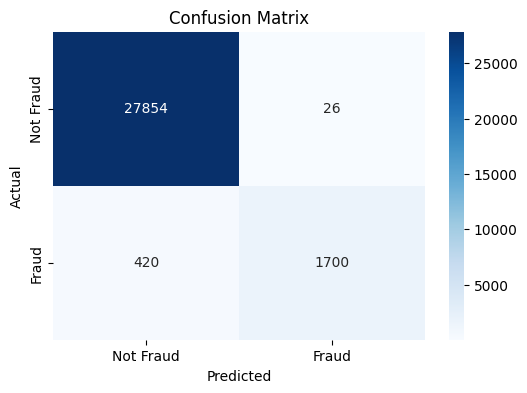

In [22]:
#Confusion Matrix
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [24]:
#classification report
# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.99      1.00      0.99     27880
        True       0.98      0.80      0.88      2120

    accuracy                           0.99     30000
   macro avg       0.99      0.90      0.94     30000
weighted avg       0.99      0.99      0.98     30000



In [ ]:
#Feature Importance Analysis
# Get feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(12,6))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Important Features in Fraud Detection")
plt.show()


AUC-ROC Score: 0.9881


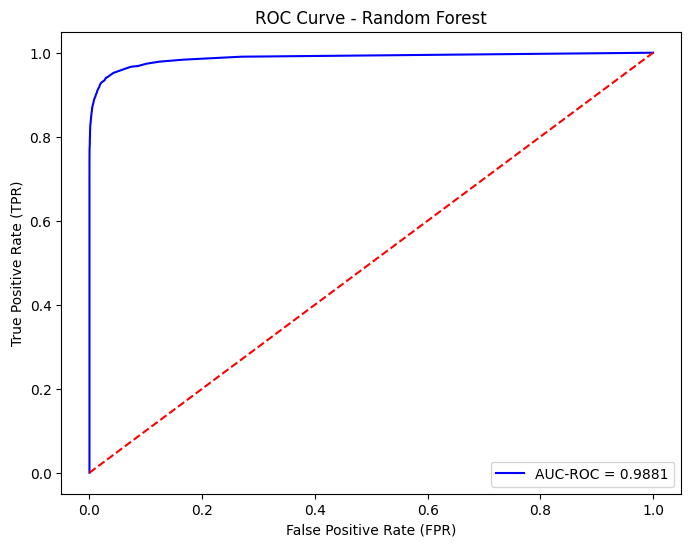

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# Predict probabilities for test data
y_probs = rf_model.predict_proba(X_test)[:, 1]  # Get probability of class 1 (fraud)
# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_probs)
print(f"AUC-ROC Score: {auc_roc:.4f}")
# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f"AUC-ROC = {auc_roc:.4f}")
plt.plot([0,1], [0,1], color='red', linestyle='--')  # Diagonal random line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


Fitting 3 folds for each of 10 candidates, totalling 30 fits

🔹 Best Parameters Found: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None}
Fine-Tuned Random Forest Model Trained Successfully!

🔹 Fine-Tuned Random Forest Performance:
Accuracy: 0.9900
Precision: 0.9633
Recall: 0.8925
F1 Score: 0.9265
AUC-ROC Score: 0.9908


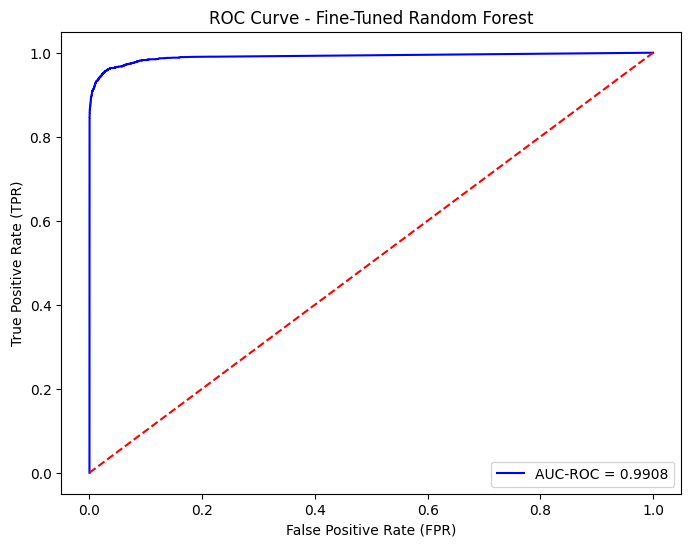

In [26]:
#RF finetuning
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300, 500],  # Number of trees in forest
    'max_depth': [5, 10, 20, None],  # Depth of each tree (None = unlimited)
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
    'max_features': ['sqrt', 'log2', None]  # Number of features per split
}

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, class_weight="balanced")

# RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=10,  # Limits search space for faster tuning
    scoring='f1',  # Optimize for F1-score to balance Precision & Recall
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1,  # Use all CPU cores
    random_state=42
)

# Fit RandomizedSearchCV on training data
random_search.fit(X_train, y_train)

# Retrieve best model
best_rf_model = random_search.best_estimator_

# Print best hyperparameters
print("\n🔹 Best Parameters Found:", random_search.best_params_)

# Train the fine-tuned Random Forest model on training data
best_rf_model.fit(X_train, y_train)

print("Fine-Tuned Random Forest Model Trained Successfully!")

# Make predictions on test data
y_pred_finetuned = best_rf_model.predict(X_test)
y_pred_proba_finetuned = best_rf_model.predict_proba(X_test)[:, 1]  # Get probability of fraud class

# Compute Evaluation Metrics
accuracy_finetuned = accuracy_score(y_test, y_pred_finetuned)
precision_finetuned = precision_score(y_test, y_pred_finetuned)
recall_finetuned = recall_score(y_test, y_pred_finetuned)
f1_finetuned = f1_score(y_test, y_pred_finetuned)

# Print Performance Metrics
print(f"\n🔹 Fine-Tuned Random Forest Performance:")
print(f"Accuracy: {accuracy_finetuned:.4f}")
print(f"Precision: {precision_finetuned:.4f}")
print(f"Recall: {recall_finetuned:.4f}")
print(f"F1 Score: {f1_finetuned:.4f}")

# Compute AUC-ROC Score
auc_roc_finetuned = roc_auc_score(y_test, y_pred_proba_finetuned)
print(f"AUC-ROC Score: {auc_roc_finetuned:.4f}")

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_finetuned)

# Plot ROC curve for fine-tuned model
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f"AUC-ROC = {auc_roc_finetuned:.4f}")
plt.plot([0,1], [0,1], color='red', linestyle='--')  # Diagonal random line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Fine-Tuned Random Forest")
plt.legend()
plt.show()


In [ ]:
# Generate confusion matrix
cm_finetuned = confusion_matrix(y_test, y_pred_finetuned)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm_finetuned, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Fine-Tuned Random Forest")
plt.show()

C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:36:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔹 XGBoost Classification Report:
              precision    recall  f1-score       support
False          0.996326  0.972776  0.984410  27880.000000
True           0.726880  0.952830  0.824658   2120.000000
accuracy       0.971367  0.971367  0.971367      0.971367
macro avg      0.861603  0.962803  0.904534  30000.000000
weighted avg   0.977286  0.971367  0.973121  30000.000000


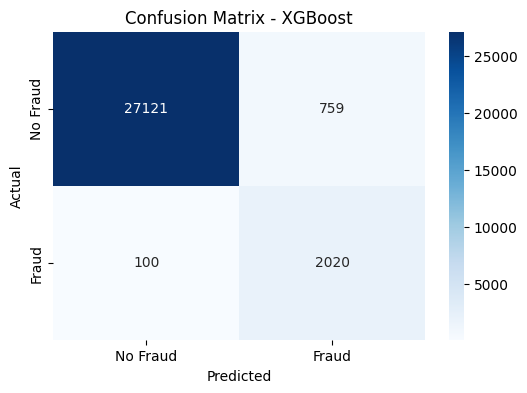


🔹 AUC Score: 0.9935


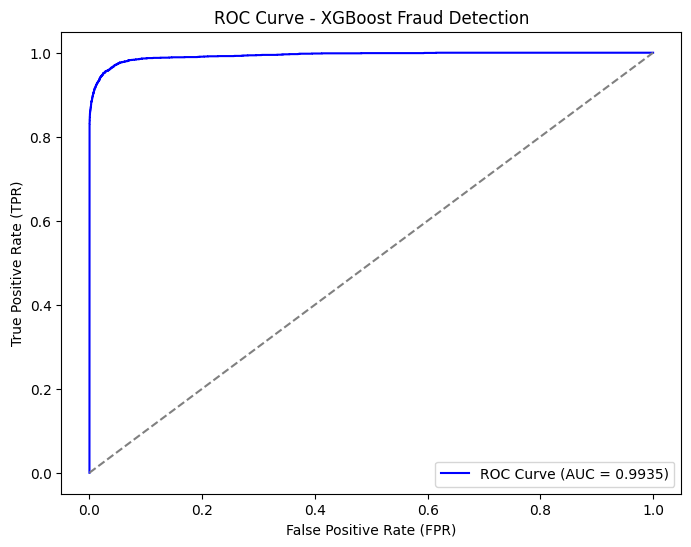

In [27]:
# Import necessary libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define Features & Target
X = df_selected.drop(columns=['is_fraud'])
y = df_selected['is_fraud']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Calculate scale_pos_weight (Legit cases / Fraud cases)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Train XGBoost with Class Weighting
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,  # Adjust class imbalance
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Get probability of fraud class

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)

# Convert classification report to DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# Print the classification report
print("\n🔹 XGBoost Classification Report:")
print(class_report_df)

# Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# Compute ROC Curve and AUC Score
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # Use y_pred_proba instead of y_pred
roc_auc = auc(fpr, tpr)

# Print AUC Score
print(f"\n🔹 AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - XGBoost Fraud Detection")
plt.legend(loc="lower right")
plt.show()


In [28]:
#decision tree
#Why max_depth=5?

#Limits tree depth to prevent overfitting.
# can tune this later (max_depth=3, max_depth=10, etc.).
#Why class_weight="balanced"?

#Since fraud cases are rare, this makes sure the model doesn’t ignore fraud transactions.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
# Define target variable
target_column = 'is_fraud'  # Make sure this column exists in your dataset

# Define feature columns (excluding the target column)
X = df_selected.drop(columns=[target_column], errors='ignore')  # Features
y = df_selected[target_column]  # Target variable
# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Print dataset sizes
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
# Initialize Decision Tree Classifier
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight="balanced")

# Train the model
dt_model.fit(X_train, y_train)

print("Decision Tree Model Trained Successfully!")

# Predict fraud on test data
y_pred = dt_model.predict(X_test)

# Predict fraud probabilities (for AUC-ROC)
y_probs = dt_model.predict_proba(X_test)[:, 1]  # Get probability of fraud (class 1)



Training set: (70000, 18), Testing set: (30000, 18)
Decision Tree Model Trained Successfully!


Accuracy: 0.9308
Precision: 0.5055
Recall: 0.9311
F1 Score: 0.6553


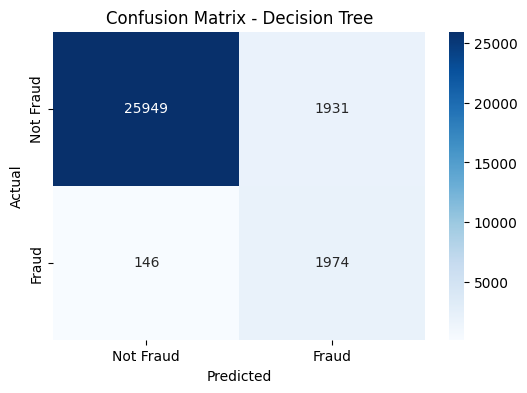

              precision    recall  f1-score   support

       False       0.99      0.93      0.96     27880
        True       0.51      0.93      0.66      2120

    accuracy                           0.93     30000
   macro avg       0.75      0.93      0.81     30000
weighted avg       0.96      0.93      0.94     30000

AUC-ROC Score: 0.9765


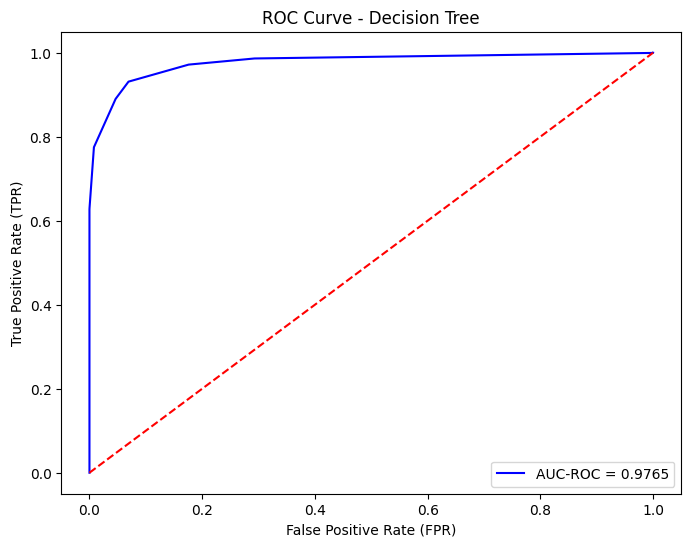

In [29]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.show()
# Print classification report
print(classification_report(y_test, y_pred))
# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_probs)
print(f"AUC-ROC Score: {auc_roc:.4f}")
# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f"AUC-ROC = {auc_roc:.4f}")
plt.plot([0,1], [0,1], color='red', linestyle='--')  # Diagonal random line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.show()


In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

# Define hyperparameter search space
param_grid = {
    'max_depth': [3, 5, 10, 15],  # Tree depth
    'min_samples_split': [2, 5, 10, 20],  # Min samples to split a node
    'min_samples_leaf': [1, 2, 5, 10]  # Min samples per leaf
}

# Initialize Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42, class_weight="balanced")

# GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring='f1',  # Optimize for F1-score
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all CPU cores
)

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Retrieve best model
best_dt_model = grid_search.best_estimator_

# Print best hyperparameters
print("\n🔹 Best Parameters Found:", grid_search.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits

🔹 Best Parameters Found: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}


Fine-Tuned Decision Tree Model Trained Successfully!

🔹 Fine-Tuned Decision Tree Performance:
Accuracy: 0.9759
Precision: 0.7788
Recall: 0.9198
F1 Score: 0.8434
AUC-ROC Score: 0.9621


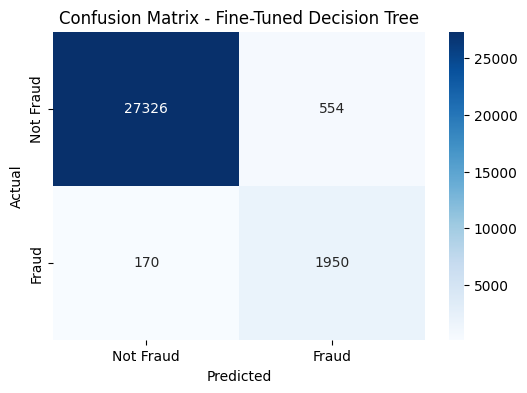

In [31]:
# Train the fine-tuned Decision Tree model
best_dt_model.fit(X_train, y_train)

print("Fine-Tuned Decision Tree Model Trained Successfully!")

# Make predictions on test data
y_pred_finetuned = best_dt_model.predict(X_test)
y_pred_proba_finetuned = best_dt_model.predict_proba(X_test)[:, 1]  # Get probability of fraud class

# Compute Evaluation Metrics
accuracy_finetuned = accuracy_score(y_test, y_pred_finetuned)
precision_finetuned = precision_score(y_test, y_pred_finetuned)
recall_finetuned = recall_score(y_test, y_pred_finetuned)
f1_finetuned = f1_score(y_test, y_pred_finetuned)

# Print Performance Metrics
print(f"\n🔹 Fine-Tuned Decision Tree Performance:")
print(f"Accuracy: {accuracy_finetuned:.4f}")
print(f"Precision: {precision_finetuned:.4f}")
print(f"Recall: {recall_finetuned:.4f}")
print(f"F1 Score: {f1_finetuned:.4f}")

# Compute AUC-ROC Score
auc_roc_finetuned = roc_auc_score(y_test, y_pred_proba_finetuned)
print(f"AUC-ROC Score: {auc_roc_finetuned:.4f}")

# Compute Confusion Matrix
cm_finetuned = confusion_matrix(y_test, y_pred_finetuned)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm_finetuned, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Fine-Tuned Decision Tree")
plt.show()

In [32]:
#KNN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
# Define target variable
target_column = 'is_fraud'  # Ensure this column exists in your dataset

# Define feature columns (excluding the target column)
X = df_selected.drop(columns=[target_column], errors='ignore')  # Features
y = df_selected[target_column]  # Target variable
# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Print dataset sizes
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
# Initialize K-Nearest Neighbors Classifier with k=5
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

print("K-Nearest Neighbors Model Trained Successfully!")
# Predict fraud on test data
y_pred = knn_model.predict(X_test)

# Predict fraud probabilities (for AUC-ROC)
y_probs = knn_model.predict_proba(X_test)[:, 1]  # Get probability of fraud (class 1)




Training set: (70000, 18), Testing set: (30000, 18)
K-Nearest Neighbors Model Trained Successfully!


Accuracy: 0.9573
Precision: 0.9783
Recall: 0.4042
F1 Score: 0.5721


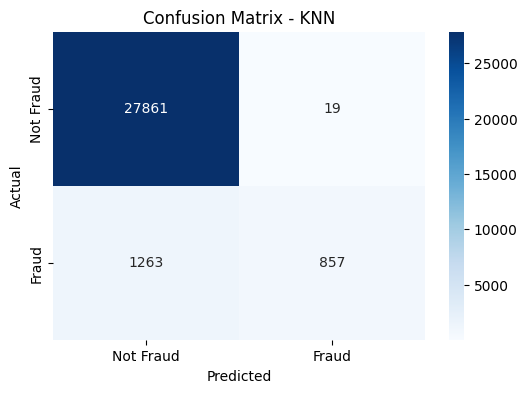

              precision    recall  f1-score   support

       False       0.96      1.00      0.98     27880
        True       0.98      0.40      0.57      2120

    accuracy                           0.96     30000
   macro avg       0.97      0.70      0.77     30000
weighted avg       0.96      0.96      0.95     30000

AUC-ROC Score: 0.8673


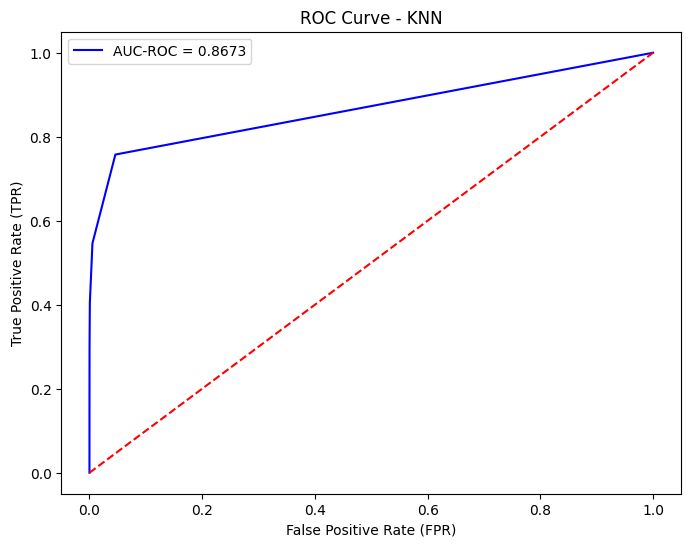

In [33]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - KNN")
plt.show()
# Print classification report
print(classification_report(y_test, y_pred))
# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_probs)
print(f"AUC-ROC Score: {auc_roc:.4f}")
# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f"AUC-ROC = {auc_roc:.4f}")
plt.plot([0,1], [0,1], color='red', linestyle='--')  # Diagonal random line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - KNN")
plt.legend()
plt.show()



In [34]:
! pip install imbalanced-learn



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Step 1: Apply SMOTE for Class Imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 2: Normalize Features (KNN is Distance-Based)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)  # Use the same scaler for test data

# Step 3: Define Hyperparameter Search Space
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],  # Test different k-values
    'weights': ['uniform', 'distance'],  # Weighting method
}

# Initialize KNN Classifier
knn_model = KNeighborsClassifier()

# GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    scoring='f1',  # Optimize for F1-score
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all CPU cores
)

# Fit GridSearchCV on training data
grid_search.fit(X_train_scaled, y_train_resampled)

# Retrieve best model
best_knn_model = grid_search.best_estimator_

# Print best hyperparameters
print("\n🔹 Best Parameters Found:", grid_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

🔹 Best Parameters Found: {'n_neighbors': 3, 'weights': 'distance'}


Fine-Tuned K-Nearest Neighbors Model Trained Successfully!

🔹 Fine-Tuned KNN Performance:
Accuracy: 0.9404
Precision: 0.5536
Recall: 0.8108
F1 Score: 0.6580
AUC-ROC Score: 0.9197


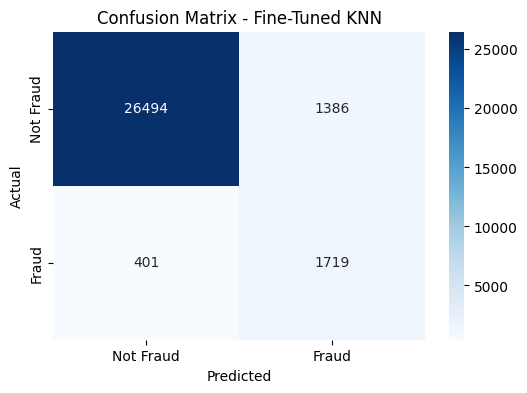

In [36]:
# Train the fine-tuned KNN model
best_knn_model.fit(X_train_scaled, y_train_resampled)

print("Fine-Tuned K-Nearest Neighbors Model Trained Successfully!")

# Make predictions on test data
y_pred_finetuned = best_knn_model.predict(X_test_scaled)
y_pred_proba_finetuned = best_knn_model.predict_proba(X_test_scaled)[:, 1]  # Get probability of fraud class

# Compute Evaluation Metrics
accuracy_finetuned = accuracy_score(y_test, y_pred_finetuned)
precision_finetuned = precision_score(y_test, y_pred_finetuned)
recall_finetuned = recall_score(y_test, y_pred_finetuned)
f1_finetuned = f1_score(y_test, y_pred_finetuned)

# Print Performance Metrics
print(f"\n🔹 Fine-Tuned KNN Performance:")
print(f"Accuracy: {accuracy_finetuned:.4f}")
print(f"Precision: {precision_finetuned:.4f}")
print(f"Recall: {recall_finetuned:.4f}")
print(f"F1 Score: {f1_finetuned:.4f}")

# Compute AUC-ROC Score
auc_roc_finetuned = roc_auc_score(y_test, y_pred_proba_finetuned)
print(f"AUC-ROC Score: {auc_roc_finetuned:.4f}")

# Compute Confusion Matrix
cm_finetuned = confusion_matrix(y_test, y_pred_finetuned)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm_finetuned, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Fine-Tuned KNN")
plt.show()

In [37]:
#SVM
#Why kernel='rbf'?

#The Radial Basis Function (RBF) kernel is commonly used for fraud detection as it handles non-linear patterns.
#You can also try 'linear' or 'poly' kernels.
#Why class_weight="balanced"?

#Since fraud cases are rare, this helps the model give more importance to them.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.sparse import csr_matrix  # For optional sparse matrix conversion
# Define target variable
target_column = 'is_fraud'  # Ensure this column exists in your dataset
X = df_selected.drop(columns=[target_column], errors='ignore')  # Features
y = df_selected[target_column]  # Target variable

# Use SAME 70-30 Train-Test Split for all models
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")





Training set: (70000, 18), Testing set: (30000, 18)


In [38]:
# Convert boolean column to integer
X_train = X_train.astype({'weekend_transaction': 'int64'})
X_test = X_test.astype({'weekend_transaction': 'int64'})

# Convert dataset to sparse matrix (faster training)
X_train_sparse = csr_matrix(X_train)
X_test_sparse = csr_matrix(X_test)

print("Sparse matrix conversion successful!")



Sparse matrix conversion successful!


In [39]:
# Train Optimized SVM Model
svm_model = LinearSVC(C=0.1, class_weight="balanced", random_state=42, dual=False, max_iter=1000)
svm_model.fit(X_train_sparse, y_train)

print("SVM Model Trained Successfully (Optimized)!")


SVM Model Trained Successfully (Optimized)!


In [40]:
# Predict fraud on test data
y_pred = svm_model.predict(X_test_sparse)


Accuracy: 0.8329
Precision: 0.2908
Recall: 0.9481
F1 Score: 0.4451


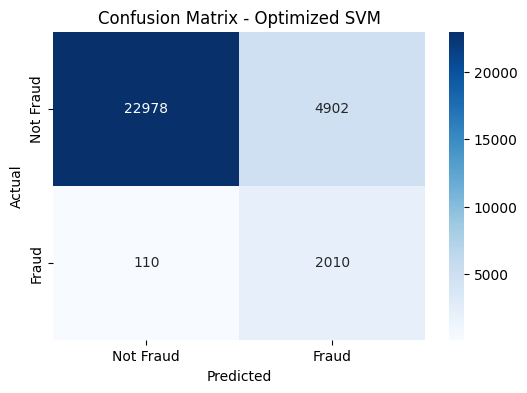

AUC-ROC Score: 0.9546


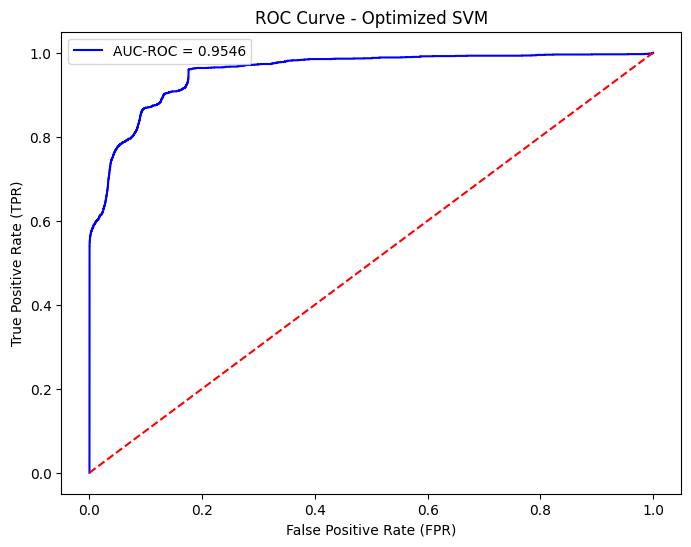

In [41]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Optimized SVM")
plt.show()
# Compute AUC-ROC score
y_scores = svm_model.decision_function(X_test_sparse)  # Faster than predict_proba()
auc_roc = roc_auc_score(y_test, y_scores)

print(f"AUC-ROC Score: {auc_roc:.4f}")
# Compute ROC curve values
fpr, tpr, _ = roc_curve(y_test, y_scores)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f"AUC-ROC = {auc_roc:.4f}")
plt.plot([0,1], [0,1], color='red', linestyle='--')  # Diagonal random line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Optimized SVM")
plt.legend()
plt.show()



In [ ]:
print(X_train.dtypes)


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

# Step 1: Prepare data
target_column = 'is_fraud'
X = df_selected.drop(columns=[target_column], errors='ignore')
y = df_selected[target_column]

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

# Step 3: SMOTE for imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 4: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Step 5: Try different C values quickly on subset
print("\n Tuning C values on smaller set:")
best_f1 = 0
best_c = None

for c in [0.1, 1, 10, 100]:
    model = SVC(C=c, kernel='rbf', gamma='scale', class_weight='balanced', probability=True, random_state=42)
    model.fit(X_train_scaled[:3000], y_train_resampled[:3000])
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)
    print(f"C = {c}, F1 Score = {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_c = c

print(f"\n✅ Best C selected: {best_c} (F1 Score = {best_f1:.4f})")

Training set: (70000, 18), Testing set: (30000, 18)

 Tuning C values on smaller set:
C = 0.1, F1 Score = 0.4357
C = 1, F1 Score = 0.6401
C = 10, F1 Score = 0.7299
C = 100, F1 Score = 0.7327

✅ Best C selected: 100 (F1 Score = 0.7327)


In [42]:
# Step 6: Retrain on full data with best C
import time
print("\n🚀 Training final model on full resampled dataset...")
start = time.time()
final_model = SVC(C=best_c, kernel='rbf', gamma='scale', class_weight='balanced', probability=False, random_state=42)
final_model.fit(X_train_scaled, y_train_resampled)
print(f"⏱️ Training time: {time.time() - start:.2f} seconds")


🚀 Training final model on full resampled dataset...
⏱️ Training time: 772.53 seconds


In [43]:
# Step 7: Final predictions and evaluation
y_pred_final = final_model.predict(X_test_scaled)
y_scores_final = final_model.decision_function(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
auc = roc_auc_score(y_test, y_scores_final)

print("\n🔹 Final SVM Model Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC-ROC  : {auc:.4f}")



🔹 Final SVM Model Performance:
Accuracy : 0.9700
Precision: 0.7489
Recall   : 0.8665
F1 Score : 0.8034
AUC-ROC  : 0.9741


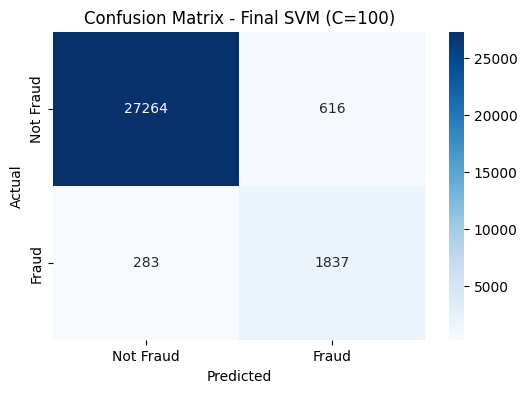

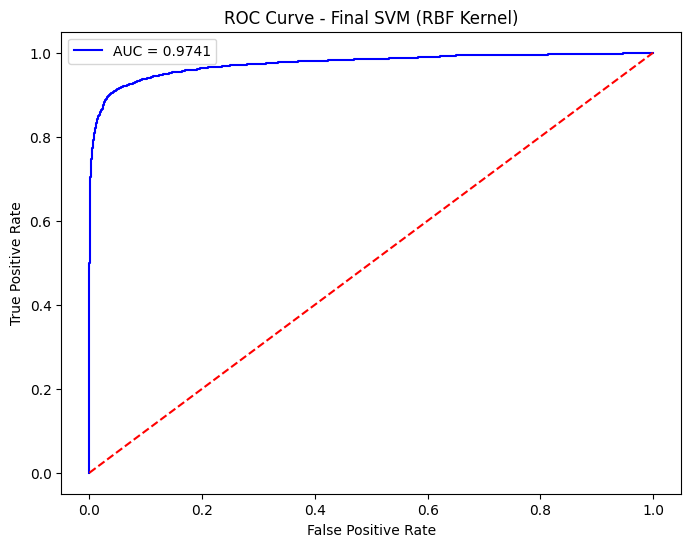

In [44]:
# Step 8: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - Final SVM (C={best_c})")
plt.show()

# Step 9: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores_final)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--', color='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Final SVM (RBF Kernel)")
plt.legend()
plt.show()

In [43]:
pip install torch torchvision torchaudio



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
# Define target variable
target_column = 'is_fraud'  # Ensure this column exists in your dataset
X = df_selected.drop(columns=[target_column], errors='ignore')  # Features
y = df_selected[target_column]  # Target variable

# Use SAME 70-30 Train-Test Split for all models
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")


Training set: (70000, 18), Testing set: (30000, 18)


In [45]:
# Convert boolean column to integer
X_train = X_train.astype({'weekend_transaction': 'int64'})
X_test = X_test.astype({'weekend_transaction': 'int64'})

print("Boolean column converted to integer!")


Boolean column converted to integer!


In [46]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Reshape for binary classification
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

print("Data converted to PyTorch tensors!")


Data converted to PyTorch tensors!


In [ ]:
print(X_train.dtypes)


In [47]:
# Define Neural Network Model
class FraudNN(nn.Module):
    def __init__(self, input_size):
        super(FraudNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize Model
input_size = X_train.shape[1]
model = FraudNN(input_size)

print("Neural Network Model Defined!")


Neural Network Model Defined!


In [48]:
# Define Loss Function & Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss function & optimizer defined!")


Loss function & optimizer defined!


In [49]:
# Training Loop
epochs = 50
batch_size = 32
num_batches = len(X_train_tensor) // batch_size

for epoch in range(epochs):
    model.train()  # Set to training mode
    epoch_loss = 0

    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()  # Reset gradients
        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/num_batches:.4f}")

print("Neural Network Training Complete!")


Epoch [1/50], Loss: 0.1839
Epoch [2/50], Loss: 0.0944
Epoch [3/50], Loss: 0.0822
Epoch [4/50], Loss: 0.0780
Epoch [5/50], Loss: 0.0747
Epoch [6/50], Loss: 0.0716
Epoch [7/50], Loss: 0.0704
Epoch [8/50], Loss: 0.0694
Epoch [9/50], Loss: 0.0688
Epoch [10/50], Loss: 0.0692
Epoch [11/50], Loss: 0.0689
Epoch [12/50], Loss: 0.0680
Epoch [13/50], Loss: 0.0674
Epoch [14/50], Loss: 0.0672
Epoch [15/50], Loss: 0.0678
Epoch [16/50], Loss: 0.0678
Epoch [17/50], Loss: 0.0671
Epoch [18/50], Loss: 0.0668
Epoch [19/50], Loss: 0.0650
Epoch [20/50], Loss: 0.0658
Epoch [21/50], Loss: 0.0659
Epoch [22/50], Loss: 0.0644
Epoch [23/50], Loss: 0.0638
Epoch [24/50], Loss: 0.0641
Epoch [25/50], Loss: 0.0634
Epoch [26/50], Loss: 0.0643
Epoch [27/50], Loss: 0.0631
Epoch [28/50], Loss: 0.0644
Epoch [29/50], Loss: 0.0633
Epoch [30/50], Loss: 0.0635
Epoch [31/50], Loss: 0.0629
Epoch [32/50], Loss: 0.0623
Epoch [33/50], Loss: 0.0622
Epoch [34/50], Loss: 0.0626
Epoch [35/50], Loss: 0.0626
Epoch [36/50], Loss: 0.0621
E

In [50]:
# Set model to evaluation mode
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor)  # Get probabilities
    y_pred = (y_pred_probs > 0.5).float()  # Convert probabilities to binary class (0 or 1)

# Convert to NumPy for Scikit-Learn metrics
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_np, y_pred_np)
precision = precision_score(y_test_np, y_pred_np)
recall = recall_score(y_test_np, y_pred_np)
f1 = f1_score(y_test_np, y_pred_np)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9787
Precision: 0.9678
Recall: 0.7231
F1 Score: 0.8278


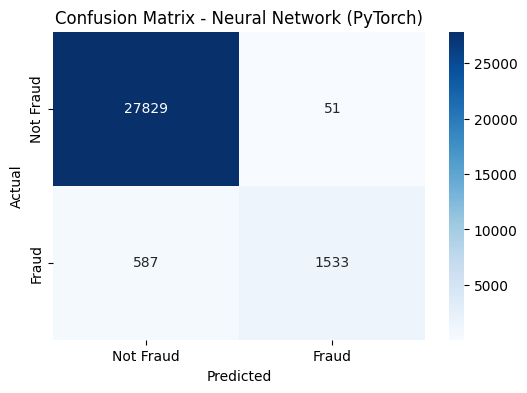

In [51]:
# Generate confusion matrix
cm = confusion_matrix(y_test_np, y_pred_np)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Neural Network (PyTorch)")
plt.show()


In [52]:
# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test_np, y_pred_probs.numpy())

print(f"AUC-ROC Score: {auc_roc:.4f}")


AUC-ROC Score: 0.9835


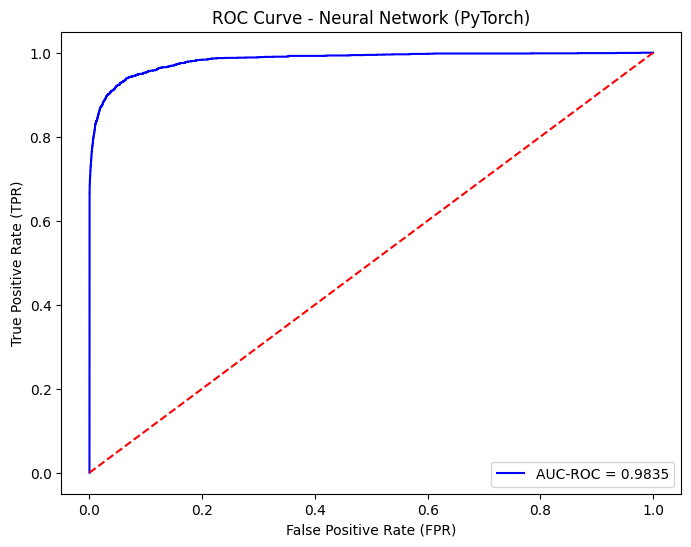

In [53]:
# Compute ROC curve values
fpr, tpr, _ = roc_curve(y_test_np, y_pred_probs.numpy())

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f"AUC-ROC = {auc_roc:.4f}")
plt.plot([0,1], [0,1], color='red', linestyle='--')  # Diagonal random line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Neural Network (PyTorch)")
plt.legend()
plt.show()


In [52]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Step 1: Prepare data
target_column = 'is_fraud'
X = df_selected.drop(columns=[target_column], errors='ignore')
y = df_selected[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Training set: (70000, 18), Testing set: (30000, 18)


In [53]:
# Convert boolean to int if needed
X_train = X_train.astype({'weekend_transaction': 'int64'})
X_test = X_test.astype({'weekend_transaction': 'int64'})

# Step 2: Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Step 4: Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

print("✅ SMOTE applied & tensors ready!")

✅ SMOTE applied & tensors ready!


Epoch [1/20], Loss: 0.0755
Epoch [2/20], Loss: 0.0972
Epoch [3/20], Loss: 0.0712
Epoch [4/20], Loss: 0.0921
Epoch [5/20], Loss: 0.0743
Epoch [6/20], Loss: 0.0849
Epoch [7/20], Loss: 0.0890
Epoch [8/20], Loss: 0.0810
Epoch [9/20], Loss: 0.0904
Epoch [10/20], Loss: 0.0676
Epoch [11/20], Loss: 0.0689
Epoch [12/20], Loss: 0.0665
Epoch [13/20], Loss: 0.0654
Epoch [14/20], Loss: 0.0697
Epoch [15/20], Loss: 0.0742
Epoch [16/20], Loss: 0.0698
Epoch [17/20], Loss: 0.0669
Epoch [18/20], Loss: 0.0667
Epoch [19/20], Loss: 0.0613
Epoch [20/20], Loss: 0.0622

🔍 Tuned NN Performance:
Accuracy : 0.0732
Precision: 0.0708
Recall   : 1.0000
F1 Score : 0.1323
AUC-ROC  : 0.9778


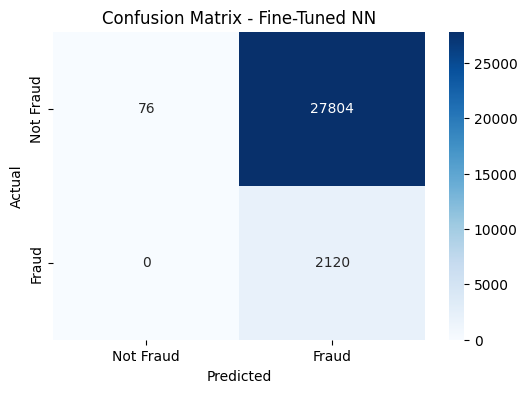

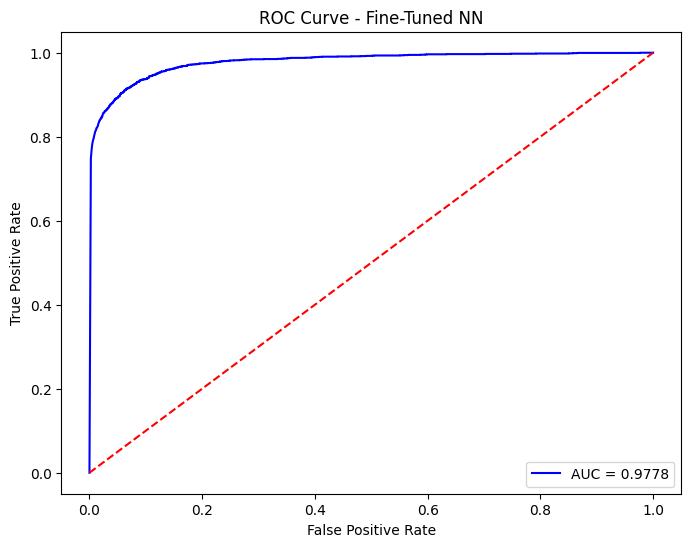

In [54]:
class FraudNN(nn.Module):
    def __init__(self, input_size):
        super(FraudNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

# Step 6: Training + Evaluation Function
def train_nn_model(learning_rate=0.001, batch_size=64, epochs=20):
    input_size = X_train_tensor.shape[1]
    model = FraudNN(input_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(0, len(X_train_tensor), batch_size):
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / (len(X_train_tensor)//batch_size):.4f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred_probs = model(X_test_tensor)
        y_pred = (y_pred_probs > 0.5).float()

    y_pred_np = y_pred.numpy()
    y_test_np = y_test_tensor.numpy()
    y_prob_np = y_pred_probs.numpy()

    accuracy = accuracy_score(y_test_np, y_pred_np)
    precision = precision_score(y_test_np, y_pred_np)
    recall = recall_score(y_test_np, y_pred_np)
    f1 = f1_score(y_test_np, y_pred_np)
    auc = roc_auc_score(y_test_np, y_prob_np)

    print(f"\n🔍 Tuned NN Performance:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC-ROC  : {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test_np, y_pred_np)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - Fine-Tuned NN")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_np, y_prob_np)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='blue')
    plt.plot([0,1], [0,1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Fine-Tuned NN")
    plt.legend()
    plt.show()

    return model

# Step 7: Call the function with your tuned hyperparameters
model = train_nn_model(learning_rate=0.001, batch_size=64, epochs=20)

In [54]:
#fine tuning xgboost
#!pip install xgboost scikit-learn
#Use RandomizedSearchCV for Faster Tuning
#Instead of testing all combinations, RandomizedSearchCV randomly selects a subset, reducing training time.
# Speeds up tuning while still optimizing key hyperparameters.
#Uses RandomizedSearchCV instead of GridSearchCV (Faster).
# Limits cv=2 instead of 3-5 (Less training time).
# Uses n_iter=10 to test only 10 random combinations (Fast but effective).
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import numpy as np

# Define Parameter Grid for Randomized Search (Reduced Search Space)
param_dist = {
    'n_estimators': [100, 300],  # Lower max estimators for faster tuning
    'max_depth': [6, 8],  # Smaller search space
    'learning_rate': [0.05, 0.1],  # Only test meaningful values
    'min_child_weight': [1, 3],  # Keeps training stable
    'gamma': [0, 0.1],  # Avoids unnecessary complexity
    'subsample': [0.8, 1.0],  # Prevents overfitting
    'colsample_bytree': [0.8, 1.0]  # Feature selection per tree
}

# Calculate class imbalance ratio
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Initialize XGBoost Model
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Handles fraud imbalance
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# Use RandomizedSearchCV Instead of GridSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,  # Only test 10 random combinations
    scoring='f1',  # Optimize for F1-score (balance between Precision & Recall)
    cv=2,  # Reduce cross-validation to 2 folds (faster)
    verbose=2,
    n_jobs=-1,  # Use all CPU cores
    random_state=42
)

# Train Model with Hyperparameter Search
random_search.fit(X_train, y_train)

# Best Model After Fine-Tuning
best_xgb_model = random_search.best_estimator_
print("\n🔹 Best Parameters Found:", random_search.best_params_)






Fitting 2 folds for each of 10 candidates, totalling 20 fits


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:05:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔹 Best Parameters Found: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}


In [101]:
#evaluate fine tune model
# Predictions
y_pred_finetuned = best_xgb_model.predict(X_test)
y_pred_proba_finetuned = best_xgb_model.predict_proba(X_test)[:, 1]  # Get probability of fraud class

# Compute Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_finetuned = accuracy_score(y_test, y_pred_finetuned)
precision_finetuned = precision_score(y_test, y_pred_finetuned)
recall_finetuned = recall_score(y_test, y_pred_finetuned)
f1_finetuned = f1_score(y_test, y_pred_finetuned)

# Print Performance Metrics
print(f"\n🔹 Fine-Tuned XGBoost Performance:")
print(f"Accuracy: {accuracy_finetuned:.4f}")
print(f"Precision: {precision_finetuned:.4f}")
print(f"Recall: {recall_finetuned:.4f}")
print(f"F1 Score: {f1_finetuned:.4f}")



🔹 Fine-Tuned XGBoost Performance:
Accuracy: 0.9889
Precision: 0.9340
Recall: 0.9075
F1 Score: 0.9206


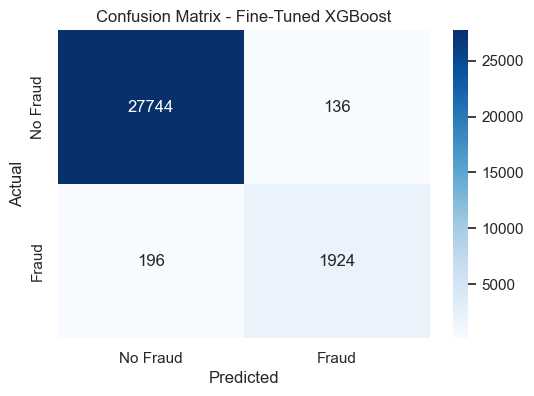

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Confusion Matrix for Fine-Tuned Model
conf_matrix_finetuned = confusion_matrix(y_test, y_pred_finetuned)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_finetuned, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Fine-Tuned XGBoost")
plt.show()



🔹 Fine-Tuned AUC-ROC Score: 0.9940


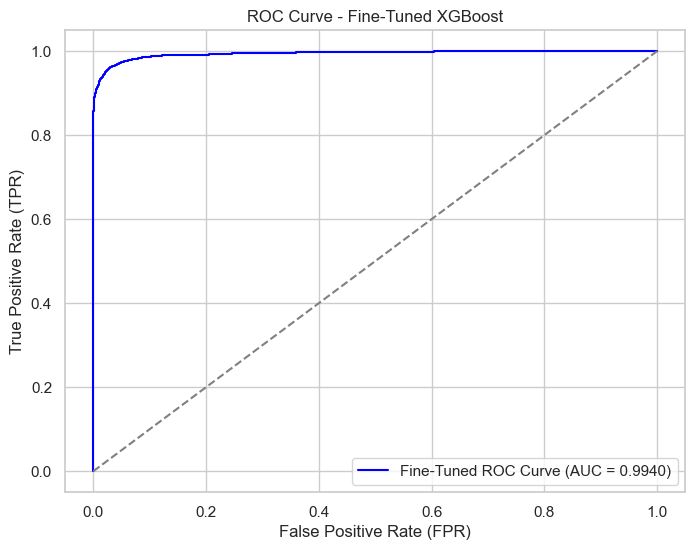

In [61]:
# Compute AUC-ROC Score
auc_roc_finetuned = roc_auc_score(y_test, y_pred_proba_finetuned)

print(f"\n🔹 Fine-Tuned AUC-ROC Score: {auc_roc_finetuned:.4f}")

# Compute ROC Curve
fpr_finetuned, tpr_finetuned, _ = roc_curve(y_test, y_pred_proba_finetuned)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr_finetuned, tpr_finetuned, color='blue', label=f'Fine-Tuned ROC Curve (AUC = {auc_roc_finetuned:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random baseline
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Fine-Tuned XGBoost")
plt.legend(loc="lower right")
plt.show()


In [55]:
! pip install hyperopt


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
# Use your already fine-tuned XGBoost model
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]  # Get fraud probability
print("\n🔹 XGBoost Predictions Generated Successfully!")



🔹 XGBoost Predictions Generated Successfully!


In [57]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import IsolationForest

# Define Parameter Distribution for Randomized Search
param_dist_if = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'contamination': [0.005, 0.01, 0.02],  # Assumed fraud %
    'max_samples': ['auto', 0.5, 0.8]  # How much data to use per tree
}

# Initialize Isolation Forest
iso_forest = IsolationForest(random_state=42)

# Run RandomizedSearchCV (Faster than GridSearchCV)
random_search_if = RandomizedSearchCV(
    estimator=iso_forest,
    param_distributions=param_dist_if,
    n_iter=5,  # Only test 5 configurations
    scoring='roc_auc',
    cv=2,
    verbose=2,
    n_jobs=-1
)

# Train Model with Hyperparameter Search
random_search_if.fit(X_train)

# Best Model After Fine-Tuning
best_iso_forest = random_search_if.best_estimator_
print("\n🔹 Best Parameters Found for Isolation Forest:", random_search_if.best_params_)

# Get anomaly scores (Higher = More Anomalous)
iso_scores = best_iso_forest.decision_function(X_test)


Fitting 2 folds for each of 5 candidates, totalling 10 fits


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(



🔹 Best Parameters Found for Isolation Forest: {'n_estimators': 200, 'max_samples': 'auto', 'contamination': 0.02}


In [58]:
from hyperopt import fmin, tpe, hp, Trials
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_auc_score
import numpy as np

# Define Objective Function for Bayesian Optimization
def objective_lof(params):
    n_neighbors = int(params['n_neighbors'])  # Ensure integer type (≥ 5)
    contamination = float(params['contamination'])  # Ensure float type

    # Train LOF model
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, 
                              contamination=contamination, 
                              novelty=True)
    lof.fit(X_train)
    
    # Get anomaly predictions
    lof_labels = lof.predict(X_test)
    lof_labels = np.where(lof_labels == -1, 1, 0)  # Convert -1 (fraud) to 1, and normal (1) to 0
    auc_score = roc_auc_score(y_test, lof_labels)
    
    return -auc_score  # Minimize negative AUC-ROC

# Define Parameter Space (Fix `n_neighbors` and `contamination`)
space_lof = {
    'n_neighbors': hp.quniform('n_neighbors', 5, 30, 5),  # Now always valid int (5, 10, 15, 20, etc.)
    'contamination': hp.uniform('contamination', 0.005, 0.02)  # Now always valid float
}

# Run Bayesian Optimization
trials = Trials()
best_lof_params = fmin(
    fn=objective_lof,
    space=space_lof,
    algo=tpe.suggest,
    max_evals=5,  # Runs only 5 evaluations (fast)
    trials=trials
)

# Train Best LOF Model
best_lof = LocalOutlierFactor(n_neighbors=int(best_lof_params['n_neighbors']), 
                              contamination=float(best_lof_params['contamination']), 
                              novelty=True)

best_lof.fit(X_train)
lof_scores = best_lof.decision_function(X_test)

print("\n🔹 Best Parameters Found for LOF:", best_lof_params)


  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



 20%|█████████▊                                       | 1/5 [00:12<00:48, 12.19s/trial, best loss: -0.5908343710240653]

C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



 40%|███████████████████▌                             | 2/5 [00:22<00:32, 10.80s/trial, best loss: -0.5908343710240653]

C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



 60%|█████████████████████████████▍                   | 3/5 [00:32<00:21, 10.68s/trial, best loss: -0.5908343710240653]

C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



 80%|███████████████████████████████████████▏         | 4/5 [00:42<00:10, 10.47s/trial, best loss: -0.5908343710240653]

C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



100%|█████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.59s/trial, best loss: -0.5908343710240653]


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



🔹 Best Parameters Found for LOF: {'contamination': np.float64(0.017226143457911156), 'n_neighbors': np.float64(15.0)}


In [62]:
# Normalize Anomaly Scores
iso_scores_norm = (iso_scores - iso_scores.min()) / (iso_scores.max() - iso_scores.min())
lof_scores_norm = (lof_scores - lof_scores.min()) / (lof_scores.max() - lof_scores.min())

# Define Objective Function
def objective_hybrid(params):
    alpha, beta, gamma = params['alpha'], params['beta'], params['gamma']
    
    # Compute Hybrid Risk Score
    hybrid_score = (alpha * y_pred_proba) + (beta * iso_scores_norm) + (gamma * lof_scores_norm)

    # Convert Risk Score to Binary Labels
    y_pred_hybrid = (hybrid_score >= 0.5).astype(int)

    # Return Negative AUC-ROC (Because Hyperopt minimizes)
    return -roc_auc_score(y_test, y_pred_hybrid)

# Define Parameter Space
space_hybrid = {
    'alpha': hp.uniform('alpha', 0.5, 0.9),
    'beta': hp.uniform('beta', 0.1, 0.3),
    'gamma': hp.uniform('gamma', 0.05, 0.2)
}

# Run Bayesian Optimization
best_hybrid_params = fmin(
    fn=objective_hybrid,
    space=space_hybrid,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

# Extract Best Values
best_alpha = best_hybrid_params['alpha']
best_beta = best_hybrid_params['beta']
best_gamma = best_hybrid_params['gamma']

print(f"\n🔹 Best Weights Found: alpha={best_alpha:.3f}, beta={best_beta:.3f}, gamma={best_gamma:.3f}")


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 54.82trial/s, best loss: -0.9599097209063101]

🔹 Best Weights Found: alpha=0.785, beta=0.278, gamma=0.163


In [60]:
# Compute Optimized Hybrid Risk Score
hybrid_score = (best_alpha * y_pred_proba) + (best_beta * iso_scores_norm) + (best_gamma * lof_scores_norm)

# Convert Hybrid Score to Binary Predictions
y_pred_hybrid = (hybrid_score >= 0.5).astype(int)

print("\n🔹 Fine-Tuned Hybrid Model Predictions Generated Successfully!")



🔹 Fine-Tuned Hybrid Model Predictions Generated Successfully!



🔹 Fine-Tuned Hybrid Model Performance:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     27880
        True       0.86      0.93      0.89      2120

    accuracy                           0.98     30000
   macro avg       0.93      0.96      0.94     30000
weighted avg       0.98      0.98      0.98     30000


🔹 AUC-ROC (Hybrid Model): 0.9592


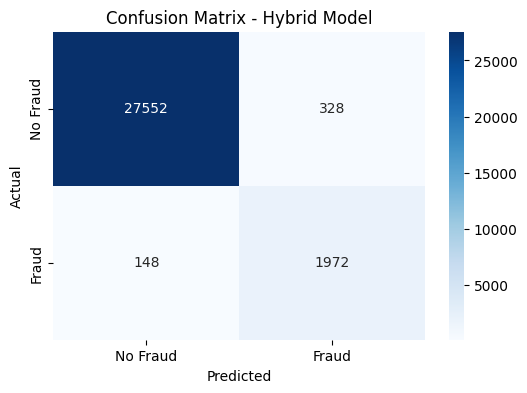

In [61]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate Hybrid Model
print("\n🔹 Fine-Tuned Hybrid Model Performance:")
print(classification_report(y_test, y_pred_hybrid))

# Compute AUC-ROC Score
hybrid_auc = roc_auc_score(y_test, y_pred_hybrid)
print(f"\n🔹 AUC-ROC (Hybrid Model): {hybrid_auc:.4f}")

# Compute Confusion Matrix
conf_matrix_hybrid = confusion_matrix(y_test, y_pred_hybrid)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_hybrid, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Hybrid Model")
plt.show()


In [109]:
import joblib

# Save XGBoost fine-tuned model
joblib.dump(random_search.best_estimator_, 'xgb_finetuned.pkl')

# Save Isolation Forest fine-tuned model
joblib.dump(random_search_if.best_estimator_, 'iso_forest_finetuned.pkl')

# Save LOF fine-tuned model
joblib.dump(best_lof, 'lof_finetuned.pkl')

# Save min-max scores for normalization (from X_test)
iso_minmax = {'min': iso_scores.min(), 'max': iso_scores.max()}
lof_minmax = {'min': lof_scores.min(), 'max': lof_scores.max()}
joblib.dump(iso_minmax, 'iso_scores_minmax.pkl')
joblib.dump(lof_minmax, 'lof_scores_minmax.pkl')



# Save best hybrid weights
joblib.dump(best_hybrid_params, 'hybrid_params.pkl')

print("\n🔹 Fine-Tuned Models and Hybrid Weights Saved Successfully!")




🔹 Fine-Tuned Models and Hybrid Weights Saved Successfully!


In [116]:
from sklearn.preprocessing import StandardScaler
import joblib
from IPython.display import display

# Features to be scaled
features_to_scale = ['log_amount', 'num_transactions_last_hour', 'total_amount_last_hour', 'velocity_risk_score']

# Display original values before scaling (optional)
display(df_selected[features_to_scale].head())

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the selected columns
df_selected[features_to_scale] = scaler.fit_transform(df_selected[features_to_scale])

# Display the scaled values (optional)
display(df_selected[features_to_scale].head())

# ✅ Save the fitted scaler for use in your Flask API
joblib.dump(scaler, 'scaler.pkl')
print("✅ StandardScaler has been fitted and saved to 'scaler.pkl'")


,log_amount,num_transactions_last_hour,total_amount_last_hour,velocity_risk_score
0,0.868403,-0.824883,-0.559456,-0.559465
1,0.460524,-0.347132,-0.269257,-0.269261
2,-0.163373,-1.154300,-0.785053,-0.785064
3,0.661101,-1.456747,-0.607018,-0.607037
4,1.142810,-1.050273,-0.723919,-0.723930


,log_amount,num_transactions_last_hour,total_amount_last_hour,velocity_risk_score
0,0.868403,-0.824883,-0.559456,-0.559465
1,0.460524,-0.347132,-0.269257,-0.269261
2,-0.163373,-1.154300,-0.785053,-0.785064
3,0.661101,-1.456747,-0.607018,-0.607037
4,1.142810,-1.050273,-0.723919,-0.723930


✅ StandardScaler has been fitted and saved to 'scaler.pkl'


In [110]:
# Load the fine-tuned models
xgb_finetuned = joblib.load('xgb_finetuned.pkl')
iso_forest_finetuned = joblib.load('iso_forest_finetuned.pkl')
lof_finetuned = joblib.load('lof_finetuned.pkl')
hybrid_params = joblib.load('hybrid_params.pkl')
# Load min-max values
iso_minmax = joblib.load('iso_scores_minmax.pkl')
lof_minmax = joblib.load('lof_scores_minmax.pkl')

print("\n🔹 Fine-Tuned Models and Hybrid Weights Loaded Successfully!")



🔹 Fine-Tuned Models and Hybrid Weights Loaded Successfully!


In [81]:
import numpy as np
import pandas as pd

# Select a single random sample from X_test
sample_index = np.random.randint(0, X_test.shape[0])  # Pick a random row index
sample_data = X_test.iloc[[sample_index]].values  # Extract sample as numpy array

# Print the selected sample for verification
print("\n🔹 Sample Data Selected for Testing:\n", pd.DataFrame(sample_data, columns=X_test.columns))



🔹 Sample Data Selected for Testing:
   merchant_category merchant_type merchant country card_type card_present  \
0                 5             4       14       0         0            0   

  device channel distance_from_home weekend_transaction time_of_day  \
0      8       0                  1               False           3   

  num_transactions_last_hour total_amount_last_hour log_amount  \
0                   0.747073                0.44114   -1.44347   

  high_transaction_flag high_spending_flag long_distance_spender  \
0                     0                  0                     0   

  velocity_risk_score  
0            0.441148  


In [82]:
import numpy as np
import pandas as pd

# Select a single random sample from X_test
sample_index = np.random.randint(0, X_test.shape[0])  # Pick a random row index
sample_data = X_test.iloc[[sample_index]].values  # Extract sample as numpy array
actual_label = y_test.iloc[sample_index]  # Get actual label

# Print the selected sample and its actual label
print("\n🔹 Sample Data Selected for Testing:")
print(pd.DataFrame(sample_data, columns=X_test.columns))
print(f"\n🔹 Actual Label: {'Fraud' if actual_label == 1 else 'Not Fraud'}")



🔹 Sample Data Selected for Testing:
  merchant_category merchant_type merchant country card_type card_present  \
0                 0            10       56       1         2            0   

  device channel distance_from_home weekend_transaction time_of_day  \
0      8       0                  0               False           3   

  num_transactions_last_hour total_amount_last_hour log_amount  \
0                   4.663476               6.462157   -0.04495   

  high_transaction_flag high_spending_flag long_distance_spender  \
0                     1                  1                     0   

  velocity_risk_score  
0            6.462171  

🔹 Actual Label: Not Fraud


In [72]:
y_pred_proba_sample = xgb_finetuned.predict_proba(sample_data)[:, 1]  # Get fraud probability


In [73]:
iso_score_sample = iso_forest_finetuned.decision_function(sample_data)  # Get anomaly score


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [74]:
lof_score_sample = lof_finetuned.decision_function(sample_data)  # Get anomaly score


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [83]:
iso_score_sample_norm = (iso_score_sample - iso_scores.min()) / (iso_scores.max() - iso_scores.min())
lof_score_sample_norm = (lof_score_sample - lof_scores.min()) / (lof_scores.max() - lof_scores.min())


In [76]:
# Extract optimized hybrid model weights
best_alpha = hybrid_params['alpha']
best_beta = hybrid_params['beta']
best_gamma = hybrid_params['gamma']

# Compute Hybrid Score
hybrid_score_sample = (best_alpha * y_pred_proba_sample) + (best_beta * iso_score_sample_norm) + (best_gamma * lof_score_sample_norm)

# Convert to binary fraud prediction
y_pred_hybrid_sample = (hybrid_score_sample >= 0.5).astype(int)

# Print the final hybrid model prediction
print(f"\n🔹 Fine-Tuned Hybrid Model Prediction: {'Fraud' if y_pred_hybrid_sample[0] == 1 else 'Not Fraud'}")



🔹 Fine-Tuned Hybrid Model Prediction: Not Fraud


In [77]:
if y_pred_hybrid_sample[0] == actual_label:
    print("\n✅ Prediction is CORRECT!")
else:
    print("\n❌ Prediction is INCORRECT!")



✅ Prediction is CORRECT!


In [ ]:
! pip install flask

In [114]:
from flask import Flask, request, jsonify
import joblib
import pyodbc
import pandas as pd
import numpy as np
import smtplib
from email.mime.text import MIMEText

app = Flask(__name__)

# Load saved models and normalization ranges
xgb_model = joblib.load('xgb_finetuned.pkl')
iso_model = joblib.load('iso_forest_finetuned.pkl')
lof_model = joblib.load('lof_finetuned.pkl')
hybrid_params = joblib.load('hybrid_params.pkl')
iso_scores = joblib.load('iso_scores_minmax.pkl')  # min-max from training
lof_scores = joblib.load('lof_scores_minmax.pkl')  # min-max from training

# Database connection string
conn_str = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=DESKTOP-EPOVRA0\\SQLEXPRESS;DATABASE=credit_card;UID=abc;PWD=abc'

# Email alert setup
def send_email_alert(transaction_id, location):
    sender = "abc.abc.2025@mumail.ie"
    receiver = "abc@gmail.com"
    subject = f"Fraud Alert: Transaction {transaction_id}"
    body = f" Suspicious Transaction Detected!\n\nTransaction ID: {transaction_id}\nLocation: {location}\nPlease investigate immediately."

    msg = MIMEText(body)
    msg['Subject'] = subject
    msg['From'] = sender
    msg['To'] = receiver
    print ("1st step ")

    with smtplib.SMTP('smtp.office365.com', 587) as server:
        server.starttls()
        server.login(sender, 'abc')
        server.sendmail(sender, receiver, msg.as_string())
        print ("2nd step")

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    try:
        features = np.array([[
            data['amount'],
            data['distance_from_home'],
            data['transaction_hour'],
            int(data['weekend_transaction'])
        ]])

        y_pred_proba = xgb_model.predict_proba(features)[:, 1]
        iso_score = iso_model.decision_function(features)
        lof_score = lof_model.decision_function(features)

        # Normalize
        iso_score_norm = (iso_score - iso_scores.min()) / (iso_scores.max() - iso_scores.min())
        lof_score_norm = (lof_score - lof_scores.min()) / (lof_scores.max() - lof_scores.min())

        alpha = hybrid_params['alpha']
        beta = hybrid_params['beta']
        gamma = hybrid_params['gamma']

        hybrid_score = (alpha * y_pred_proba) + (beta * iso_score_norm) + (gamma * lof_score_norm)
        y_pred = int(hybrid_score >= 0.5)

        # Update DB
        with pyodbc.connect(conn_str) as conn:
            cursor = conn.cursor()
            cursor.execute("UPDATE transactions SET is_fraud = ? WHERE transaction_id = ?", (y_pred, data['transaction_id']))
            conn.commit()
            print ("3rd step")

        if y_pred == 1:
            send_email_alert(data['transaction_id'], data['city'])

        return jsonify({"prediction": y_pred, "hybrid_score": float(hybrid_score[0])})

    except Exception as e:
        return jsonify({"error": str(e)}), 500

if __name__ == '__main__':
    app.run(debug=True, port=5000)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

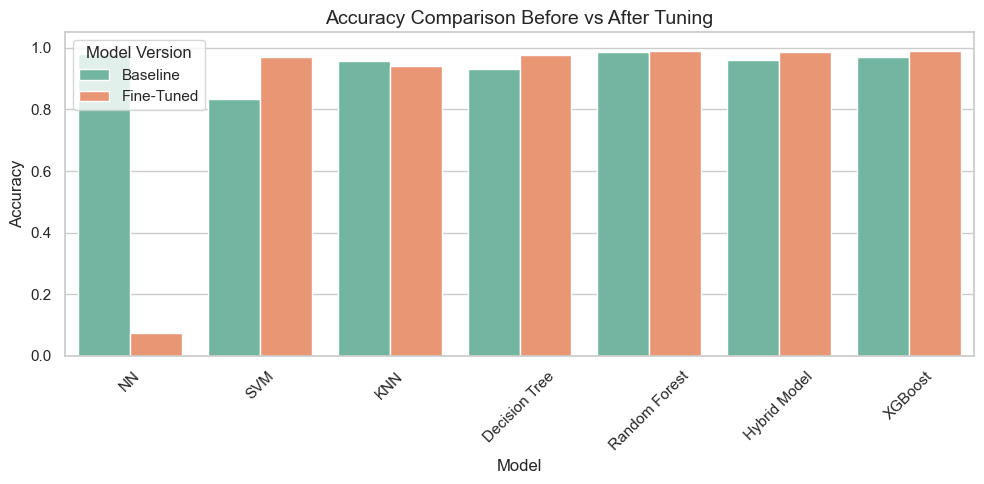

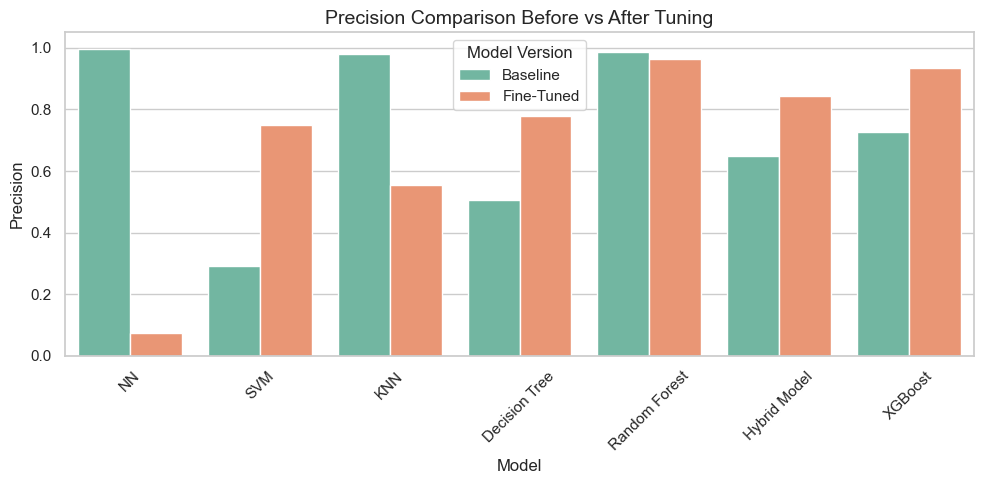

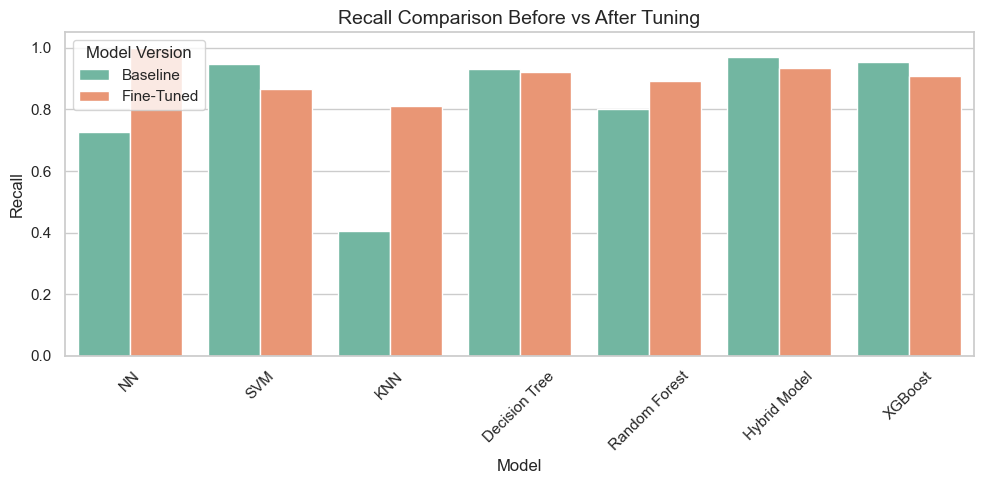

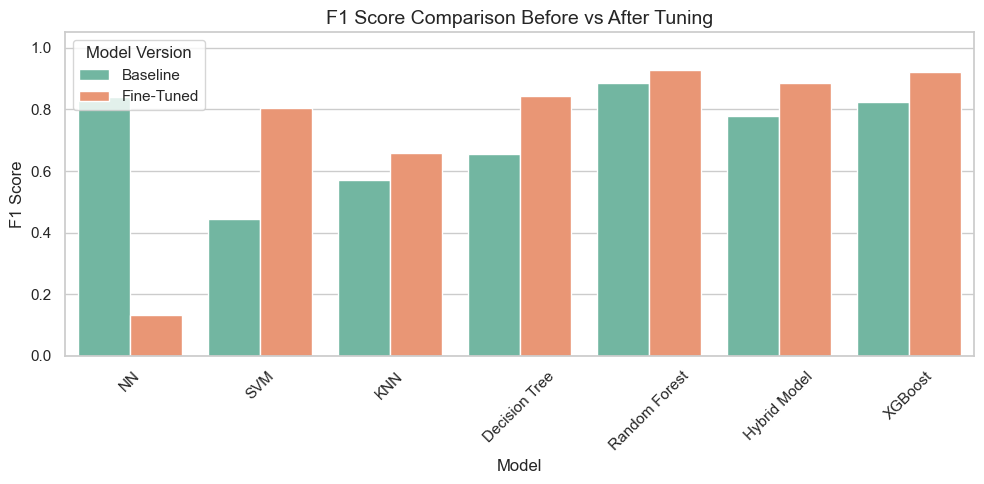

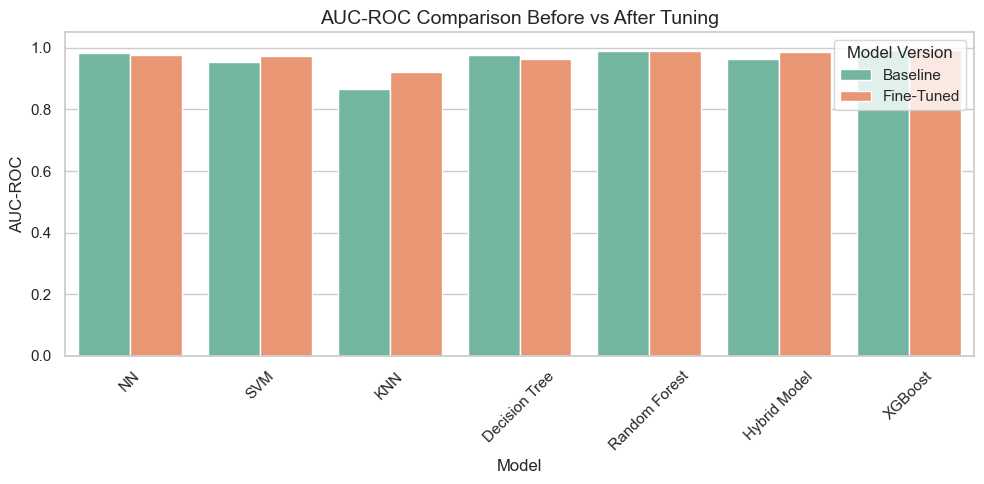

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style
sns.set(style="whitegrid")

# Step 1: Define results
model_names = ['NN', 'SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Hybrid Model', 'XGBoost']

metrics_data = {
    'Accuracy':      [(0.9805, 0.0732), (0.8329, 0.9700), (0.9573, 0.9404), (0.9308, 0.9759), (0.9851, 0.9900), (0.96, 0.986), (0.9714, 0.9889)],
    'Precision':     [(0.9968, 0.0732), (0.2908, 0.7489), (0.9783, 0.5536), (0.5055, 0.7788), (0.9849, 0.9633), (0.65, 0.8423), (0.7269, 0.934)],
    'Recall':        [(0.7269, 1.0), (0.9481, 0.8665), (0.4042, 0.8108), (0.9311, 0.9198), (0.8019, 0.8925), (0.97, 0.933), (0.9528, 0.9075)],
    'F1 Score':      [(0.8407, 0.1323), (0.4451, 0.8034), (0.5721, 0.6580), (0.6553, 0.8434), (0.884, 0.9265), (0.78, 0.8855), (0.8247, 0.9206)],
    'AUC-ROC':       [(0.9839, 0.9778), (0.9546, 0.9741), (0.8673, 0.9197), (0.9765, 0.9621), (0.9881, 0.9908), (0.9628, 0.9874), (0.9935, 0.994)]
}

# Step 2: Plot each metric
for metric, values in metrics_data.items():
    baseline = [v[0] for v in values]
    tuned = [v[1] for v in values]

    df_plot = pd.DataFrame({
        'Model': model_names * 2,
        'Performance': baseline + tuned,
        'Version': ['Baseline'] * len(model_names) + ['Fine-Tuned'] * len(model_names)
    })

    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_plot, x='Model', y='Performance', hue='Version', palette='Set2')
    plt.title(f"{metric} Comparison Before vs After Tuning", fontsize=14)
    plt.ylim(0, 1.05)
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend(title="Model Version")
    plt.tight_layout()
    plt.show()


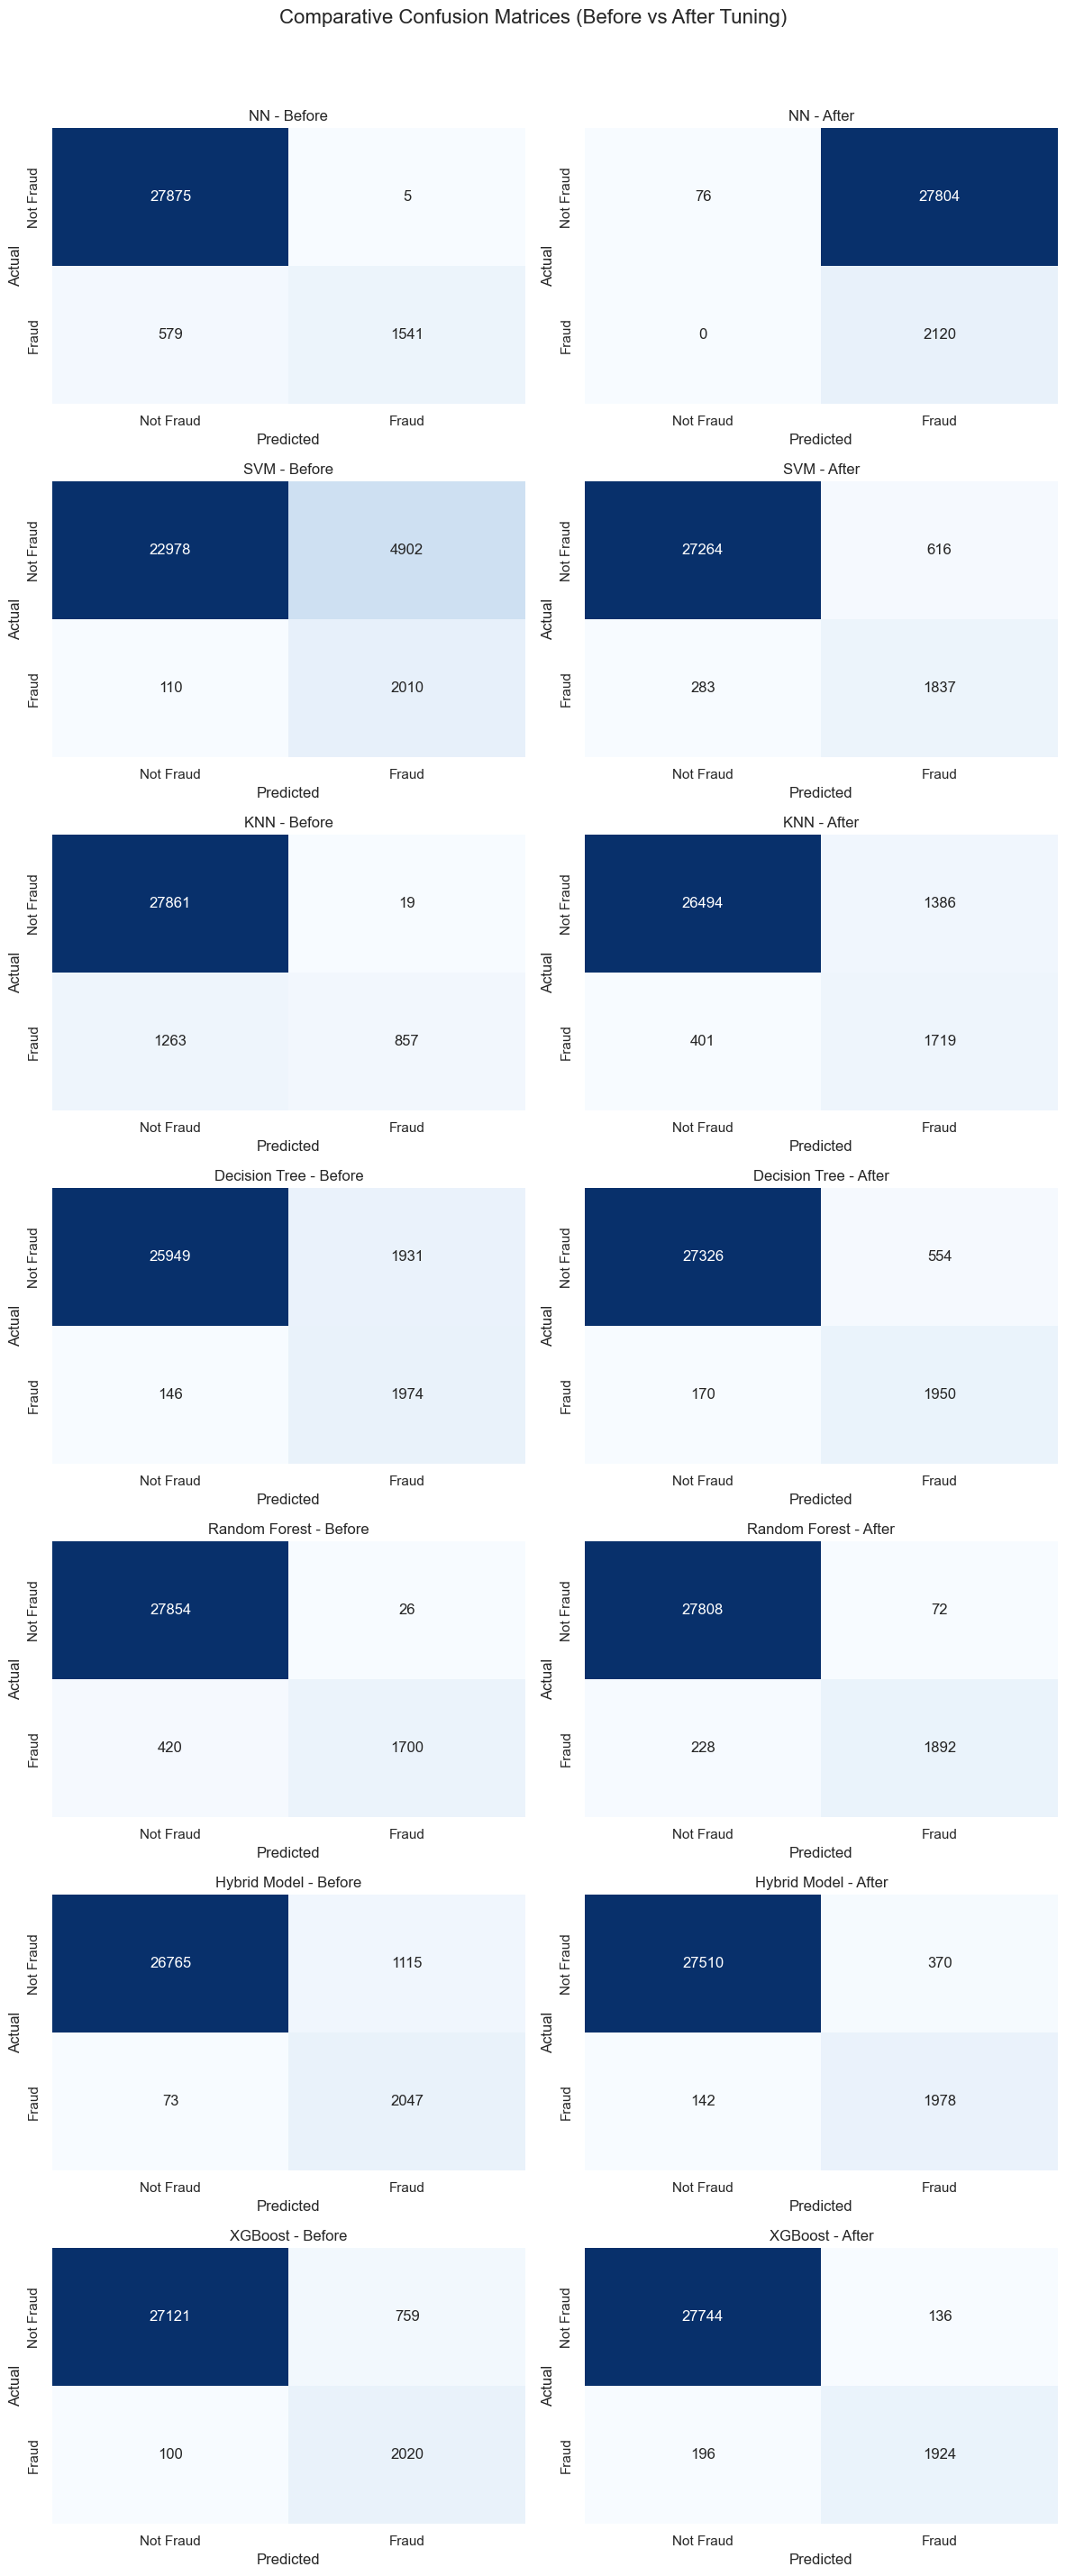

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Define confusion matrices (TN, FP, FN, TP)
conf_matrices = {
    'NN': {
        'Before': np.array([[27875, 5], [579, 1541]]),
        'After':  np.array([[76, 27804], [0, 2120]])
    },
    'SVM': {
        'Before': np.array([[22978, 4902], [110, 2010]]),
        'After':  np.array([[27264, 616], [283, 1837]])
    },
    'KNN': {
        'Before': np.array([[27861, 19], [1263, 857]]),
        'After':  np.array([[26494, 1386], [401, 1719]])
    },
    'Decision Tree': {
        'Before': np.array([[25949, 1931], [146, 1974]]),
        'After':  np.array([[27326, 554], [170, 1950]])
    },
    'Random Forest': {
        'Before': np.array([[27854, 26], [420, 1700]]),
        'After':  np.array([[27808, 72], [228, 1892]])
    },
    'Hybrid Model': {
        'Before': np.array([[26765, 1115], [73, 2047]]),
        'After':  np.array([[27510, 370], [142, 1978]])
    },
    'XGBoost': {
        'Before': np.array([[27121, 759], [100, 2020]]),
        'After':  np.array([[27744, 136], [196, 1924]])
    }
}

# Step 2: Plot
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(12, 28))
plt.subplots_adjust(hspace=0.5)

for i, (model, results) in enumerate(conf_matrices.items()):
    for j, (version, cm) in enumerate(results.items()):
        ax = axes[i, j]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'], ax=ax)
        ax.set_title(f"{model} - {version}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

plt.suptitle("Comparative Confusion Matrices (Before vs After Tuning)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [115]:
import joblib

# Load your trained model (pipeline or standalone)
model_path = 'C:/Users/Debrachoubey/xgb_finetuned.pkl'
model = joblib.load(model_path)

print("✅ Model loaded.")

# Try to get feature names
try:
    # Case 1: It's a Pipeline and contains a preprocessor (ColumnTransformer)
    if hasattr(model, 'named_steps'):
        print("\n🔍 Detected Pipeline:")
        if 'preprocessor' in model.named_steps:
            preprocessor = model.named_steps['preprocessor']
            if hasattr(preprocessor, 'feature_names_in_'):
                print("\n📌 Feature names used in training:")
                for f in preprocessor.feature_names_in_:
                    print(f)
            else:
                print("⚠️ 'preprocessor' does not have feature_names_in_ attribute.")
        else:
            print("⚠️ No 'preprocessor' step found in the pipeline. Can't extract feature names.")
    
    # Case 2: Standalone model trained with DataFrame
    elif hasattr(model, 'feature_names_in_'):
        print("\n📌 Feature names used in training:")
        for f in model.feature_names_in_:
            print(f)
    
    else:
        print("❌ Unable to extract feature names. The model may not have been trained with column names.")

except Exception as e:
    print(f"❌ Error while extracting feature names: {e}")


✅ Model loaded.

📌 Feature names used in training:
merchant_category
merchant_type
merchant
country
card_type
card_present
device
channel
distance_from_home
weekend_transaction
time_of_day
num_transactions_last_hour
total_amount_last_hour
log_amount
high_transaction_flag
high_spending_flag
long_distance_spender
velocity_risk_score
